In [10]:
import numpy as np
import torch
from easydict import EasyDict as edict
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch import LongTensor, FloatTensor, Tensor
from torch_geometric.nn import GINConv, global_max_pool
import torch.nn as nn
from torch_geometric.data import InMemoryDataset, Data, Batch
from typing_extensions import Literal
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from typing import Tuple, List, Optional, Set
import networkx as nx
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import to_networkx, remove_self_loops
from functools import partial
from tqdm.notebook import trange
import math
import matplotlib.pyplot as plt

In [22]:
class Args:
    """A class containing arguments used for setting up the dataset and model."""
    batch_size: int = 32  # Batch size for the training loop.
    num_workers: int = 2  # Number of workers to use for the data loader.
    learning_rate: float = 0.001  # Learning rate.
    weight_decay: float = 5e-4  # Weight decay.
    num_epochs: int = 200  # Number of training epochs.
    num_layers: int = 3  # Number of message passing layers in the GNN model.
    hidden_features: int = 32  # Dimensionality of the hidden layers in the GNN.
    dropout: float = 0.2  # Dropout probability.
    seed: int = 42  # Random seed.

args = Args()

In [23]:
rng = np.random.default_rng(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [24]:
mutag_dataset = edict()
mutag_dataset.ds = TUDataset(
    './dataset/mutag/',
    name='MUTAG',
    use_node_attr=True,
    use_edge_attr=True
)
mutag_dataset.ds.shuffle()
mutag_size = len(mutag_dataset.ds)
mutag_dataset.train_ds = mutag_dataset.ds[:int(0.8 * mutag_size)]
mutag_dataset.valid_ds = mutag_dataset.ds[int(0.8 * mutag_size) : int(0.9 * mutag_size)]
mutag_dataset.test_ds = mutag_dataset.ds[int(0.9 * mutag_size):]

# Since MUTAG has multiple graphs, we use DataLoaders to load the graphs
mutag_train_loader = DataLoader(
    dataset=mutag_dataset.train_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=True
)
mutag_valid_loader = DataLoader(
    dataset=mutag_dataset.valid_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=False
    )
mutag_test_loader = DataLoader(
    dataset=mutag_dataset.test_ds,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    shuffle=False
)

In [25]:
for i, mutag_data in enumerate(mutag_dataset.ds[82]):
    print(mutag_data)

('edge_index', tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,
          7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 15],
        [ 1, 12,  0,  2,  1,  3,  2,  4, 11,  3,  5,  4,  6, 10,  5,  7,  6,  8,
         13,  7,  9,  8, 10,  5,  9, 11,  3, 10, 12,  0, 11,  7, 14, 15, 13, 13]]))
('x', tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]]))
('edge_attr', tensor([[0., 1., 0., 0.],
 

In [26]:
class GIN_SubgraphX(torch.nn.Module):
    """The GIN model from the SubgraphX paper.

    Adapted from https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py
    """
    def __init__(self, 
                in_channels: int, 
                hidden_channels: int, 
                num_layers: int, 
                out_channels: int, 
                dropout: float = 0.5):
        super(GIN_SubgraphX, self).__init__()

        self.dropout = dropout

        convs_list = [
            GINConv(nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU())
            )
        ]
        convs_list += [
            GINConv(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU())
            )
            for _ in range(num_layers - 1)
        ]

        self.convs = nn.ModuleList(convs_list)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels), 
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, 
                x: LongTensor, 
                edge_index: LongTensor, 
                batch: LongTensor) -> FloatTensor:
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index)

        x = global_max_pool(x, batch)

        x = self.classifier(x)

        return x

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
mutag_model = GIN_SubgraphX(
    in_channels=mutag_dataset.ds.num_features,
    hidden_channels=args.hidden_features,
    num_layers=args.num_layers,
    out_channels=1,
    dropout=args.dropout
).to(device)

print('MUTAG model')
print(mutag_model)

mutag_optimizer = torch.optim.Adam(
    mutag_model.parameters(),
    lr=args.learning_rate, 
    weight_decay=args.weight_decay
)

MUTAG model
GIN_SubgraphX(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [29]:
class AverageMeter(object):
    """The AverageMeter keeps track of an average value over multiple updates."""
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        """Resets the meter."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        """Updates the meter with a value and a count.

        :param val: The value to add to the running sum.
        :param n: The count, i.e., the number of items included in val.
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
def run_epoch_node_cls(dataset: InMemoryDataset,
                       model: nn.Module,
                       optimizer: torch.optim.Adam,
                       device: torch.device,
                       mode: Literal['train', 'valid', 'test'] = False) -> None:
    """Runs an epoch (train or eval) of a node classification model/dataset."""
    epoch_loss = AverageMeter()
    epoch_acc = AverageMeter()
    data = dataset.ds.data.to(device)

    if mode == 'train':
        model.train()
        idx = dataset.train_idx
    else:
        model.eval()
        idx = dataset.valid_idx

    if mode == 'train':
        optimizer.zero_grad() 

    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[idx], data.y[idx])

    if mode == 'train':
        loss.backward()
        optimizer.step()  

    epoch_loss.update(loss.detach().item(), out.shape[0]) 
    batch_acc = ((torch.argmax(out[idx], dim=1)) == data.y[idx]).float().mean()
    epoch_acc.update(batch_acc, out.shape[0])

    print(f'{mode} loss in the epoch: {epoch_loss.avg:.3f}, {mode} accuracy in the epoch: {epoch_acc.avg:.3f}')

In [31]:
def run_epoch_graph_cls(loader: DataLoader,
                        model: nn.Module,
                        optimizer: torch.optim.Adam,
                        device: torch.device,
                        mode: Literal['train', 'valid', 'test'] = False) -> None:
    """Runs an epoch (train or eval) of a graph classification model/dataset."""
    epoch_loss = AverageMeter()
    epoch_acc = AverageMeter()

    if mode == 'train':
        model.train()
    else:
        model.eval()

    preds, targets = [], []

    for batch in loader:
        batch = batch.to(device)

        if mode == 'train':
            optimizer.zero_grad()

        out = model(batch.x.float(), batch.edge_index, batch.batch) # input of mutag model

        pred = out.squeeze()
        target = batch.y.float().squeeze()

        preds.append(pred.detach().cpu().numpy())
        targets.append(target.detach().cpu().numpy())

        loss = F.binary_cross_entropy_with_logits(
            input=pred,
            target=target
        )

        if mode == 'train':
            loss.backward()
            optimizer.step()

        epoch_loss.update(loss.detach().item(), out.shape[0])
        
        batch_acc = ((torch.sigmoid(out) > 0.5).int().flatten() == batch.y).float().mean()
        epoch_acc.update(batch_acc, out.shape[0])

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    epoch_auc = roc_auc_score(y_true=targets, y_score=preds)

    print(f'{mode} loss in the epoch: {epoch_loss.avg:.3f}, '
          f'{mode} accuracy in the epoch: {epoch_acc.avg:.3f}, '
          f'{mode} auc in the epoch: {epoch_auc:.3f}')

In [32]:
# Train MUTAG model
for epoch in range(args.num_epochs):
    print(f'Epoch {epoch}')

    # Train loop
    run_epoch_graph_cls(
        loader=mutag_train_loader,
        model=mutag_model,
        optimizer=mutag_optimizer,
        device=device,
        mode='train'
    )

    # Validation loop
    run_epoch_graph_cls(
        loader=mutag_valid_loader,
        model=mutag_model,
        optimizer=mutag_optimizer,
        device=device,
        mode='valid'
    )

# Test loop
run_epoch_graph_cls(
    loader=mutag_test_loader,
    model=mutag_model,
    optimizer=mutag_optimizer,
    device=device,
    mode='test'
)

Epoch 0
train loss in the epoch: 0.673, train accuracy in the epoch: 0.660, train auc in the epoch: 0.452
valid loss in the epoch: 0.651, valid accuracy in the epoch: 0.737, valid auc in the epoch: 0.929
Epoch 1
train loss in the epoch: 0.664, train accuracy in the epoch: 0.660, train auc in the epoch: 0.566
valid loss in the epoch: 0.636, valid accuracy in the epoch: 0.737, valid auc in the epoch: 0.929
Epoch 2
train loss in the epoch: 0.655, train accuracy in the epoch: 0.660, train auc in the epoch: 0.573
valid loss in the epoch: 0.618, valid accuracy in the epoch: 0.737, valid auc in the epoch: 0.929
Epoch 3
train loss in the epoch: 0.647, train accuracy in the epoch: 0.660, train auc in the epoch: 0.605
valid loss in the epoch: 0.598, valid accuracy in the epoch: 0.737, valid auc in the epoch: 0.929
Epoch 4
train loss in the epoch: 0.632, train accuracy in the epoch: 0.660, train auc in the epoch: 0.670
valid loss in the epoch: 0.570, valid accuracy in the epoch: 0.737, valid auc 

In [33]:
class MCTSNode(object):
    """A node in a Monte Carlo Tree Search representing a subgraph."""

    def __init__(self,
                 coalition: Tuple[int, ...],
                 data: Data,
                 ori_graph: nx.Graph,
                 c_puct: float,
                 W: float = 0,
                 N: int = 0,
                 P: float = 0) -> None:
        """Initializes the MCTSNode object.

        :param coalition: A tuple of the nodes in the subgraph represented by this MCTSNode.
        :param data: The full graph.
        :param ori_graph: The original graph in NetworkX format.
        :param W: The sum of the node value.
        :param N: The number of times of arrival at this node.
        :param P: The property score (reward) of this node.
        :param c_puct: The hyperparameter that encourages exploration.
        """
        self.coalition = coalition
        self.data = data
        self.ori_graph = ori_graph
        self.c_puct = c_puct
        self.W = W
        self.N = N
        self.P = P
        self.children: List[MCTSNode] = []

    def Q(self) -> float:
        """Value that encourages exploitation of nodes with high reward."""
        return self.W / self.N if self.N > 0 else 0.0

    def U(self, n: int) -> float:
        """Value that encourages exploration of nodes with few visits."""
        return self.c_puct * self.P * math.sqrt(n) / (1 + self.N)

    @property
    def size(self) -> int:
        """Returns the number of nodes in the subgraph represented by the MCTSNode."""
        return len(self.coalition)

In [34]:
def gnn_score(coalition: Tuple[int, ...], data: Data, model: torch.nn.Module) -> float:
    """Computes the GNN score of the subgraph with the selected coalition of nodes.

    :param coalition: A list of indices of the nodes to retain in the induced subgraph.
    :param data: A data object containing the full graph.
    :param model: The GNN model to use to compute the score.
    :return: The score of the GNN model applied to the subgraph induced by the provided coalition of nodes.
    """
    node_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=data.x.device)
    node_mask[list(coalition)] = 1

    row, col = data.edge_index
    edge_mask = (node_mask[row] == 1) & (node_mask[col] == 1)

    mask_edge_index = data.edge_index[:, edge_mask]

    mask_data = Data(x=data.x, edge_index=mask_edge_index)
    mask_data = Batch.from_data_list([mask_data])

    logits = model(x=mask_data.x, edge_index=mask_data.edge_index, batch=mask_data.batch)
    score = torch.sigmoid(logits).item()

    return score


def get_best_mcts_node(results: List[MCTSNode], max_nodes: int) -> MCTSNode:
    """Get the MCTSNode with the highest reward (and smallest graph if tied) that has at most max_nodes nodes.

    :param results: A list of MCTSNodes.
    :param max_nodes: The maximum number of nodes allowed in a subgraph represented by an MCTSNode.
    :return: The MCTSNode with the highest reward (and smallest graph if tied) that has at most max_nodes nodes.
    """
    # Filter subgraphs to only include those with at most max_nodes nodes
    results = [result for result in results if result.size <= max_nodes]

    # Check that there exists a subgraph with at most max_nodes nodes
    if len(results) == 0:
        raise ValueError(f'All subgraphs have more than {max_nodes} nodes.')

    # Sort subgraphs by size in case of a tie (max picks the first one it sees, so the smaller one)
    results = sorted(results, key=lambda result: result.size)

    # Find the subgraph with the highest reward and break ties by preferring a smaller graph
    best_result = max(results, key=lambda result: (result.P, -result.size))

    return best_result

In [35]:
class MCTS(object):
    """An object which runs Monte Carlo Tree Search to find optimal subgraphs of a graph."""

    def __init__(self,
                 x: FloatTensor,
                 edge_index: LongTensor,
                 model: torch.nn.Module,
                 num_hops: int,
                 n_rollout: int,
                 min_nodes: int,
                 c_puct: float,
                 num_expand_nodes: int,
                 high2low: bool) -> None:
        """Creates the Monte Carlo Tree Search (MCTS) object.

        :param x: Input node features.
        :param edge_index: The edge indices.
        :param model: The GNN model to explain.
        :param num_hops: The number of hops to extract the neighborhood of target node.
        :param n_rollout: The number of times to build the Monte Carlo tree.
        :param min_nodes: Number of graph nodes of the leaf node in the search tree.
        :param c_puct: The hyperparameter that encourages exploration.
        :param num_expand_nodes: The number of nodes to expand when extending the child nodes in the search tree.
        :param high2low: Whether to expand children nodes from high degree to low degree
                         when extending the child nodes in the search tree.
        """
        self.x = x
        self.edge_index = edge_index
        self.model = model
        self.num_hops = num_hops
        self.data = Data(x=self.x, edge_index=self.edge_index)
        self.graph = to_networkx(
            Data(x=self.x, edge_index=remove_self_loops(self.edge_index)[0]),
            to_undirected=True
        )
        self.data = Batch.from_data_list([self.data])
        self.num_nodes = self.graph.number_of_nodes()
        self.n_rollout = n_rollout
        self.min_nodes = min_nodes
        self.c_puct = c_puct
        self.num_expand_nodes = num_expand_nodes
        self.high2low = high2low

        self.root_coalition = tuple(range(self.num_nodes))
        self.MCTSNodeClass = partial(MCTSNode, data=self.data, ori_graph=self.graph, c_puct=self.c_puct)
        self.root = self.MCTSNodeClass(coalition=self.root_coalition)
        self.state_map = {self.root.coalition: self.root}

    def mcts_rollout(self, tree_node: MCTSNode) -> float:
        """Performs a Monte Carlo Tree Search rollout.

        :param tree_node: An MCTSNode representing the root of the MCTS search.
        :return: The value (reward) of the rollout.
        """
        if len(tree_node.coalition) <= self.min_nodes:
            return tree_node.P

        # Expand if this node has never been visited
        if len(tree_node.children) == 0:
            # Maintain a set of all the coalitions added as children of the tree
            tree_children_coalitions = set()

            # Get subgraph induced by the tree
            tree_subgraph = self.graph.subgraph(tree_node.coalition)

            # Get nodes to try expanding
            all_nodes = sorted(
                tree_subgraph.nodes,
                key=lambda node: tree_subgraph.degree[node],
                reverse=self.high2low
            )
            all_nodes_set = set(all_nodes)

            expand_nodes = all_nodes[:self.num_expand_nodes]

            # For each node, prune it and get the remaining subgraph (only keep the largest connected component)
            for expand_node in expand_nodes:
                subgraph_coalition = all_nodes_set - {expand_node}

                subgraphs = (
                    self.graph.subgraph(connected_component)
                    for connected_component in nx.connected_components(self.graph.subgraph(subgraph_coalition))
                )

                subgraph = max(subgraphs, key=lambda subgraph: subgraph.number_of_nodes())

                new_coalition = tuple(sorted(subgraph.nodes()))

                # Check the state map and merge with an existing subgraph if available
                new_node = self.state_map.setdefault(new_coalition, self.MCTSNodeClass(coalition=new_coalition))

                # Add the subgraph to the children of the tree
                if new_coalition not in tree_children_coalitions:
                    tree_node.children.append(new_node)
                    tree_children_coalitions.add(new_coalition)

            # For each child in the tree, compute its reward using the GNN
            for child in tree_node.children:
                if child.P == 0:
                    child.P = gnn_score(coalition=child.coalition, data=child.data, model=self.model)

        # Select the best child node and unroll it
        sum_count = sum(child.N for child in tree_node.children)
        selected_node = max(tree_node.children, key=lambda x: x.Q() + x.U(n=sum_count))
        v = self.mcts_rollout(tree_node=selected_node)
        selected_node.W += v
        selected_node.N += 1

        return v

    def run_mcts(self) -> List[MCTSNode]:
        """Runs the Monte Carlo Tree search.

        :return: A list of MCTSNode objects representing subgraph explanations sorted from highest to
                 smallest reward (for ties, the smaller graph is first).
        """
        for _ in trange(self.n_rollout):
            self.mcts_rollout(tree_node=self.root)

        explanations = [node for _, node in self.state_map.items()]

        # Sort by highest reward and break ties by preferring a smaller graph
        explanations = sorted(explanations, key=lambda x: (x.P, -x.size), reverse=True)

        return explanations

In [36]:
class SubgraphX(object):
    """An object which contains methods to explain a GNN's prediction on a graph in terms of subgraphs."""

    def __init__(self,
                 model: torch.nn.Module,
                 num_hops: Optional[int] = None,
                 n_rollout: int = 20,
                 min_nodes: int = 5,
                 c_puct: float = 10.0,
                 num_expand_nodes: int = 14,
                 high2low: bool = False) -> None:
        """Initializes the SubgraphX object.

        :param model: The GNN model to explain.
        :param num_hops: The number of hops to extract the neighborhood of target node.
                         If None, uses the number of MessagePassing layers in the model.
        :param n_rollout: The number of times to build the Monte Carlo tree.
        :param min_nodes: Number of graph nodes of the leaf node in the search tree.
        :param c_puct: The hyperparameter that encourages exploration.
        :param num_expand_nodes: The number of nodes to expand when extending the child nodes in the search tree.
        :param high2low: Whether to expand children nodes from high degree to low degree
                         when extending the child nodes in the search tree.
        """
        self.model = model
        self.model.eval()
        self.num_hops = num_hops

        if self.num_hops is None:
            self.num_hops = sum(isinstance(module, MessagePassing) for module in self.model.modules())

        # MCTS hyperparameters
        self.n_rollout = n_rollout
        self.min_nodes = min_nodes
        self.c_puct = c_puct
        self.num_expand_nodes = num_expand_nodes
        self.high2low = high2low

    def explain(self, x: Tensor, edge_index: Tensor, max_nodes: int) -> MCTSNode:
        """Explain the GNN behavior for the graph using the SubgraphX method.

        :param x: Node feature matrix with shape [num_nodes, dim_node_feature].
        :param edge_index: Graph connectivity in COO format with shape [2, num_edges].
        :param max_nodes: The maximum number of nodes in the final explanation results.
        :return: The MCTSNode corresponding to the subgraph that best explains the model's prediction on the graph
                 (the smallest graph that has the highest reward such that the subgraph has at most max_nodes nodes).
        """
        # Create an MCTS object with the provided graph
        mcts = MCTS(
            x=x,
            edge_index=edge_index,
            model=self.model,
            num_hops=self.num_hops,
            n_rollout=self.n_rollout,
            min_nodes=self.min_nodes,
            c_puct=self.c_puct,
            num_expand_nodes=self.num_expand_nodes,
            high2low=self.high2low
        )

        # Run the MCTS search
        mcts_nodes = mcts.run_mcts()

        # Select the MCTSNode that contains the smallest subgraph that has the highest reward
        # such that the subgraph has at most max_nodes nodes
        best_mcts_node = get_best_mcts_node(mcts_nodes, max_nodes=max_nodes)

        return best_mcts_node

In [37]:
def visualize_subgraph_mutag(graph: nx.Graph,
                             node_set: Optional[Set[int]] = None,
                             edge_set: Optional[Set[int]] = None,
                             title: Optional[str] = None) -> None:
    """Visualizes a subgraph explanation for a graph from the MUTAG dataset.

    Note: Only provide subgraph_node_set or subgraph_edge_set, not both.

    Adapted from https://github.com/divelab/DIG/blob/dig/dig/xgraph/method/subgraphx.py

    :param graph: A NetworkX graph object representing the full graph.
    :param node_set: A set of nodes that induces a subgraph.
    :param edge_set: A set of edges that induces a subgraph.
    :param title: Optional title for the plot.
    """
    if node_set is None:
        node_set = set(graph.nodes())

    if edge_set is None:
        edge_set = {(n_from, n_to) for (n_from, n_to) in graph.edges() if n_from in node_set and n_to in node_set}

    node_dict = {0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'I', 5: 'Cl', 6: 'Br'}
    node_idxs = {node: node_x.index(1.0) for node, node_x in graph.nodes(data='x')}
    node_labels = {k: node_dict[v] for k, v in node_idxs.items()}
    node_color = ['#E49D1C', '#4970C6', '#FF5357', '#29A329', 'brown', 'darkslategray', '#F0EA00']
    colors = [node_color[v % len(node_color)] for k, v in node_idxs.items()]

    pos = nx.kamada_kawai_layout(graph)

    nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=list(graph.nodes()), node_color=colors, node_size=300)
    nx.draw_networkx_edges(G=graph, pos=pos, width=3, edge_color='gray', arrows=False)
    nx.draw_networkx_edges(G=graph, pos=pos, edgelist=list(edge_set), width=6, edge_color='black', arrows=False)
    print(list(edge_set))
    nx.draw_networkx_labels(G=graph, pos=pos, labels=node_labels)

    if title is not None:
        plt.title(title)

    plt.axis('off')
    plt.show()
    plt.close()

In [39]:
num_nodes = 10
subgraphx = SubgraphX(model=mutag_model, min_nodes=num_nodes)

original = []
new = []
for i, mutag_data in enumerate(mutag_dataset.ds[:188]):
    print(mutag_data)
    subgraph = subgraphx.explain(x=mutag_data.x.to(device), edge_index=mutag_data.edge_index.to(device), max_nodes=num_nodes)
    original_logit = torch.sigmoid(mutag_model(subgraph.data.x.float(), subgraph.data.edge_index, subgraph.data.batch))
    original.append(float(original_logit))
    important_node = torch.tensor([i for i in subgraph.coalition]).to(device)
    important_subgraph = subgraph.data.subgraph(important_node)
    new_logit = torch.sigmoid(mutag_model(important_subgraph.x.float(), important_subgraph.edge_index, important_subgraph.batch))
    new.append(float(new_logit))

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 40], x=[18, 7], edge_attr=[40, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[18, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 66], x=[27, 7], edge_attr=[66, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[13, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[23, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[24, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[23, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 30], x=[14, 7], edge_attr=[30, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[17, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 32], x=[15, 7], edge_attr=[32, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 32], x=[15, 7], edge_attr=[32, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 42], x=[19, 7], edge_attr=[42, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 42], x=[19, 7], edge_attr=[42, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 30], x=[14, 7], edge_attr=[30, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 58], x=[25, 7], edge_attr=[58, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 40], x=[19, 7], edge_attr=[40, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 48], x=[23, 7], edge_attr=[48, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 42], x=[19, 7], edge_attr=[42, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 30], x=[14, 7], edge_attr=[30, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[18, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 20], x=[10, 7], edge_attr=[20, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 56], x=[25, 7], edge_attr=[56, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 58], x=[25, 7], edge_attr=[58, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 40], x=[19, 7], edge_attr=[40, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 56], x=[25, 7], edge_attr=[56, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 40], x=[18, 7], edge_attr=[40, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 56], x=[26, 7], edge_attr=[56, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 56], x=[25, 7], edge_attr=[56, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 66], x=[28, 7], edge_attr=[66, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[24, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[13, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 20], x=[10, 7], edge_attr=[20, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 56], x=[25, 7], edge_attr=[56, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 48], x=[21, 7], edge_attr=[48, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[17, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[14, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 40], x=[19, 7], edge_attr=[40, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[21, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[14, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[20, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[14, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[24, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 52], x=[23, 7], edge_attr=[52, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[13, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[24, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 48], x=[22, 7], edge_attr=[48, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 46], x=[22, 7], edge_attr=[46, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 66], x=[28, 7], edge_attr=[66, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 30], x=[14, 7], edge_attr=[30, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[13, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 48], x=[21, 7], edge_attr=[48, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 36], x=[16, 7], edge_attr=[36, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


  0%|          | 0/20 [00:00<?, ?it/s]

[(9, 10), (3, 4), (4, 6), (2, 3), (6, 7), (4, 5), (8, 9), (3, 9), (8, 13), (7, 8)]


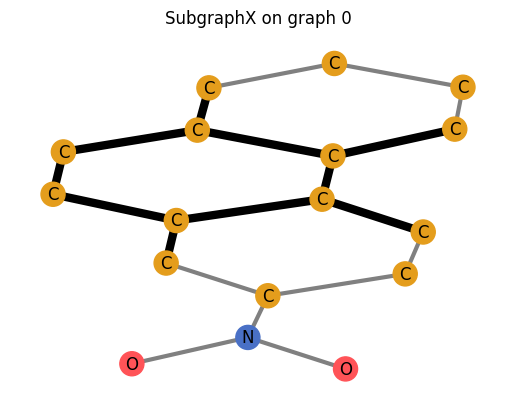

In [37]:
# Run SubgraphX and visualize the best subgraph for each graph
num_nodes = 10
subgraphx = SubgraphX(model=mutag_model, min_nodes=num_nodes)

for i, mutag_data in enumerate(mutag_dataset.ds[:1]):
    print(mutag_data)
    graph = to_networkx(mutag_data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
    subgraph = subgraphx.explain(x=mutag_data.x.to(device), edge_index=mutag_data.edge_index.to(device), max_nodes=num_nodes)
    print(subgraph)
    visualize_subgraph_mutag(
        graph=graph,
        node_set=set(subgraph.coalition),
        title=f'SubgraphX on graph {i}'
    )

In [19]:
print(78, " original: ", original[78])
print(78, " new: ", new[78])
print(155, " original: ", original[155])
print(155, " new: ", new[155])
print(185, " original: ", original[185])
print(185, " new: ", new[185])

78  original:  0.6442285180091858
78  new:  0.7702257037162781
155  original:  0.2901879549026489
155  new:  0.2901879549026489
185  original:  0.28270286321640015
185  new:  0.28270286321640015


In [20]:
import math
log = []
for i in range(len(new)):
    a = math.log(new[i] / (1 - new[i]))
    b = math.log(original[i] / (1 - original[i]))
    log.append(b - a)

In [21]:
log.sort()

In [22]:
log

[-1.4425060747419574,
 -1.2611550532162241,
 -1.0311470526516284,
 -0.9320021488800414,
 -0.9149661459303717,
 -0.8852010414514746,
 -0.8713669002678077,
 -0.8566304730064225,
 -0.7144959902776469,
 -0.680784467503492,
 -0.624960689198935,
 -0.621634707556538,
 -0.6158212024287787,
 -0.6046587209535472,
 -0.6013539717213146,
 -0.5931089354858168,
 -0.5915443388691046,
 -0.5903546759038614,
 -0.5787341199170255,
 -0.573490569333694,
 -0.5641702757713833,
 -0.5636130216676447,
 -0.5636130216676447,
 -0.5611946636783607,
 -0.544865130890881,
 -0.5447936520709222,
 -0.5438054669412065,
 -0.5438054669412065,
 -0.5281142575675162,
 -0.5239187410548967,
 -0.519475050496462,
 -0.4770470488022047,
 -0.43771763516130235,
 -0.43225880628873714,
 -0.43112284988324046,
 -0.41004964505091035,
 -0.40963402048721476,
 -0.40661362232702236,
 -0.4013087215241953,
 -0.39740387299604446,
 -0.3550538104602454,
 -0.3550538104602454,
 -0.3444563638460574,
 -0.3444563638460574,
 -0.3428799137763612,
 -0.32280

In [40]:
new_pred = np.array([1 if i > 0.5 else 0 for i in new])
original_pred = np.array([1 if i > 0.5 else 0 for i in original])
truth = []
for i, mutag_data in enumerate(mutag_dataset.ds[:188]):
    truth.append(int(mutag_data.y))
fidel = []
for i in range(len(truth)):
    a = 0
    b = 0
    if (truth[i] == original_pred[i]):
        a = 1
    if (truth[i] == new_pred[i]):
        b = 1
    fidel.append(a - b)
    print(truth[i], " ", original_pred[i], " ", new_pred[i])
fidelity = sum(fidel) / len(fidel)
print("fidelity- is: ", fidelity)

1   1   1
0   0   0
0   0   0
1   1   1
0   0   0
1   1   1
0   1   1
1   1   1
0   0   0
1   1   1
1   1   1
1   1   1
1   1   1
0   0   0
1   1   1
1   1   1
0   0   0
1   1   1
0   0   0
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   0   0
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
0   1   1
1   1   1
0   1   1
1   0   0
0   1   1
0   0   1
0   1   1
1   1   1
0   0   0
1   1   1
1   1   1
1   0   0
1   1   1
1   1   1
1   1   1
1   0   0
1   0   1
1   1   1
1   1   1
1   1   1
1   1   1
0   1   1
1   0   0
1   1   1
1   1   1
1   1   1
1   0   1
1   1   1
0   0   0
1   0   0
1   1   1
0   1   1
0   1   1
1   1   1
1   1   1
1   1   1
0   0   1
1   1   1
1   1   1
0   1   1
1   1   1
1   1   1
0   0   0
0   1   1
0   1   1
1   1   1
1   1   1
1   0   0
1   1   1
1   0   1
0   0   0
1   1   1
1   1   1
1   1   1
0   0   0
0   0   0
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
1   1   1
0   0   1
1   1   1
0   1   1


In [41]:
true_negative = 0
true_positive = 0
false_negative = 0
false_positive = 0
for i in range(188):
    if (truth[i] == 0):
        if (original_pred[i] == 0):
            true_negative += 1
        else:
            false_positive += 1
    else:
        if (original_pred[i] == 0):
            false_negative += 1
        else:
            true_positive += 1
            
print("true_negative", true_negative)
print("true_positive", true_positive)
print("false_negative", false_negative)
print("false_positive", false_positive)

true_negative 47
true_positive 105
false_negative 20
false_positive 16


In [42]:
precision = true_positive / (true_positive + false_positive)
print(precision)
recall = true_positive / (true_positive + false_negative)
print(recall)

0.8677685950413223
0.84


In [43]:
posi = 0
for i in range(188):
    if (truth[i] == 0):
        posi+=1
print(posi)

63


In [24]:
fidel_p = []
for i in range(len(new)):
    fidel_p.append(original[i] - new[i])
fidelity_p = sum(fidel_p) / len(fidel_p)
print("fidelity- prob is: ", fidelity_p)

fidelity- prob is:  -0.012470929625820606


  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


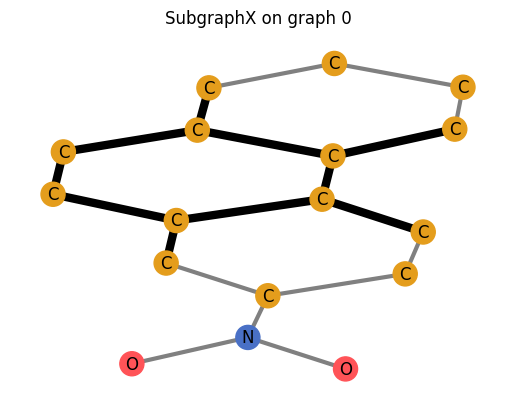

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


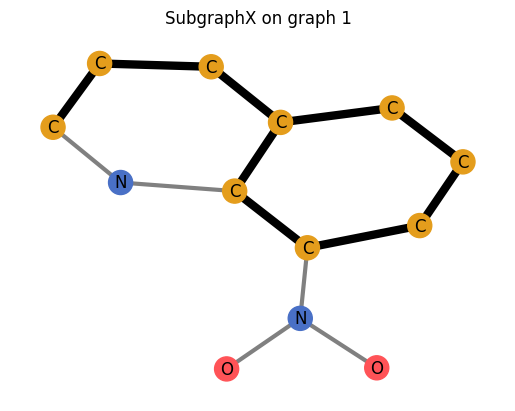

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


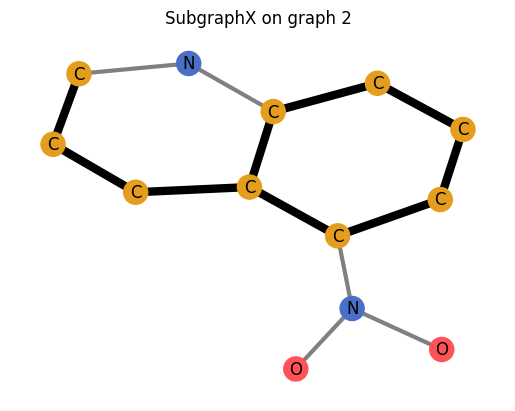

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


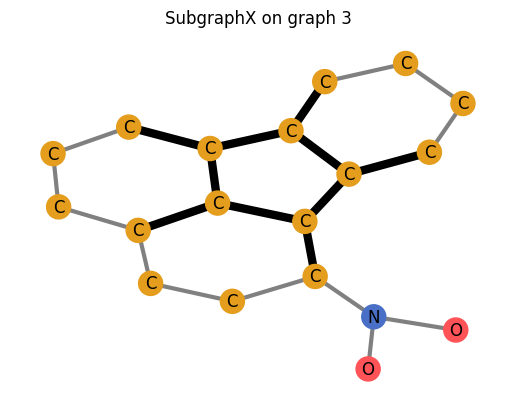

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


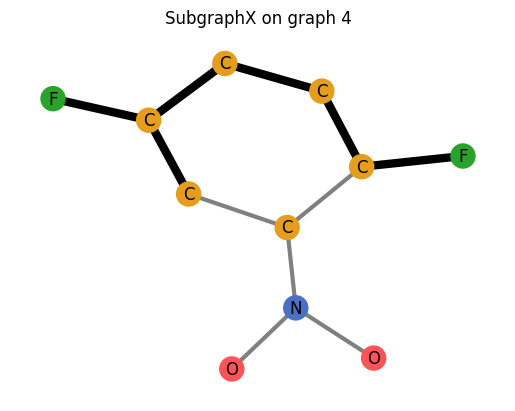

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


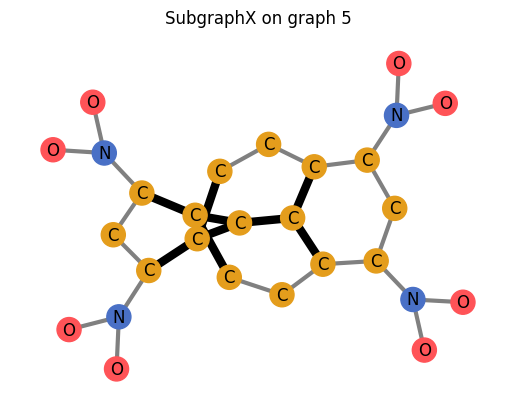

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


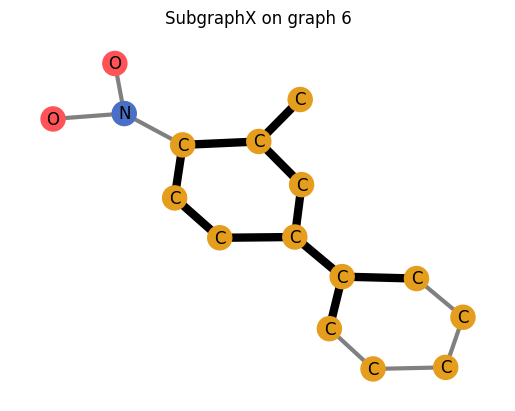

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


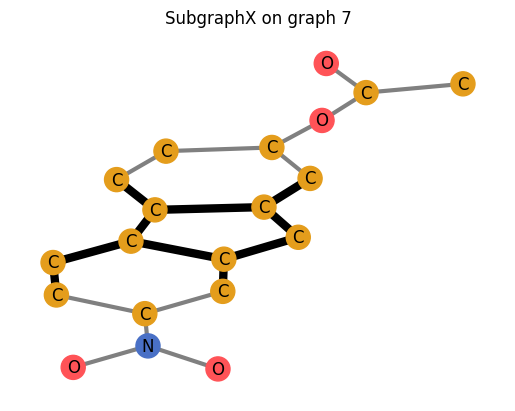

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


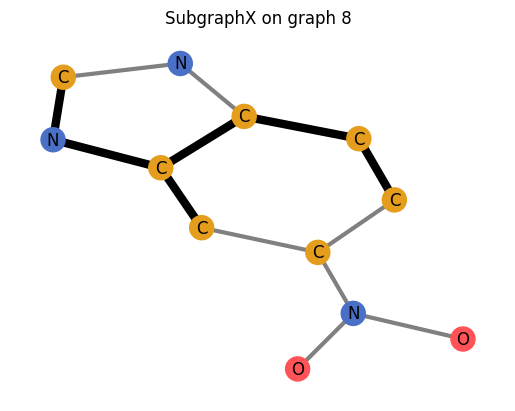

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


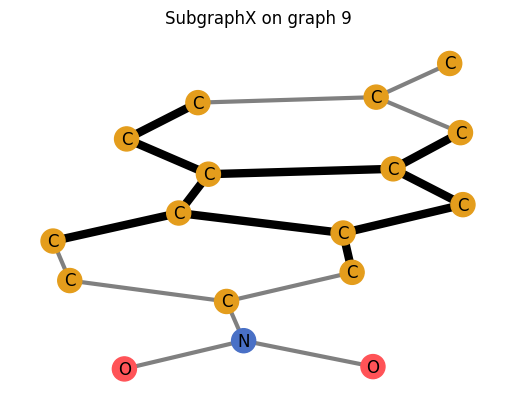

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


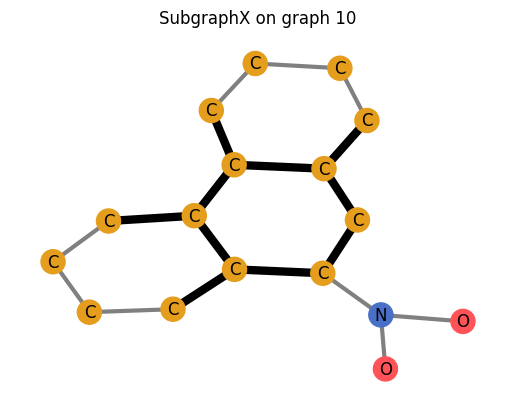

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


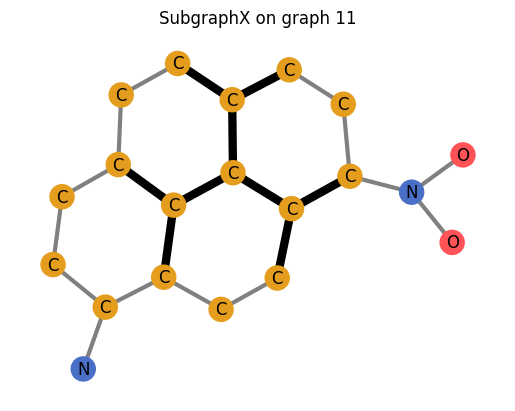

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


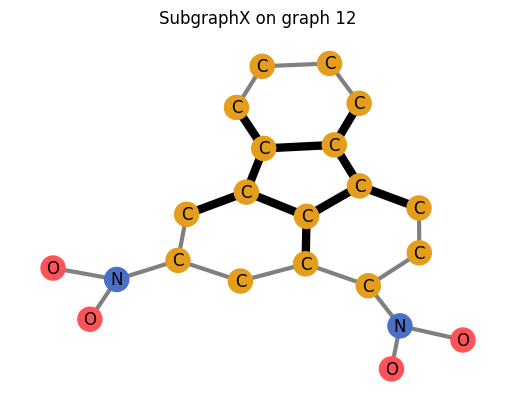

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


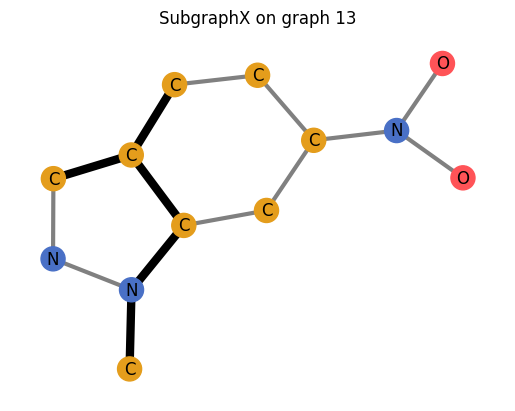

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


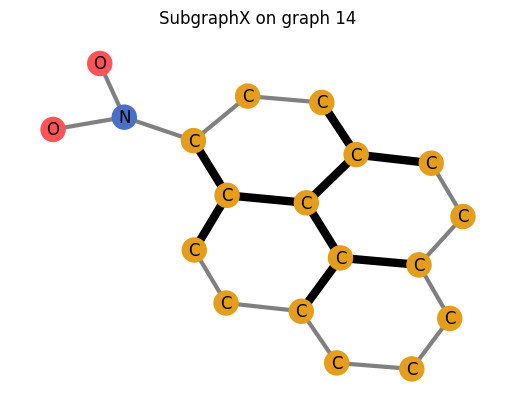

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


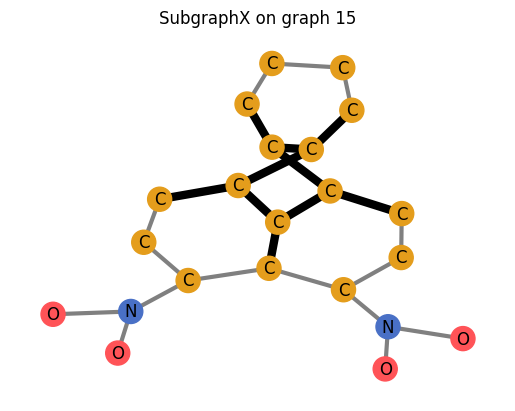

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


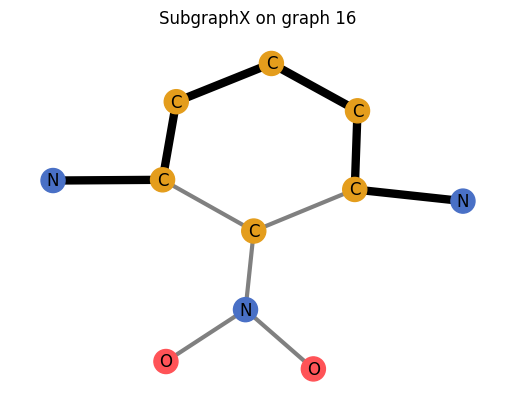

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


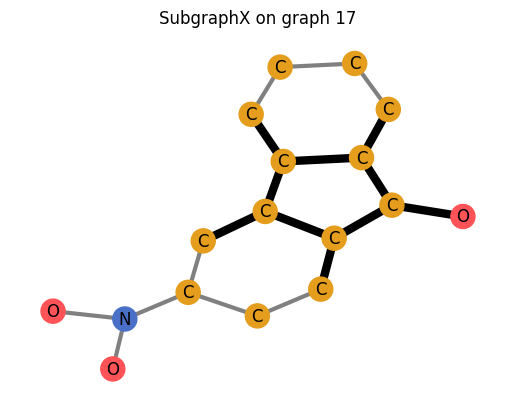

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


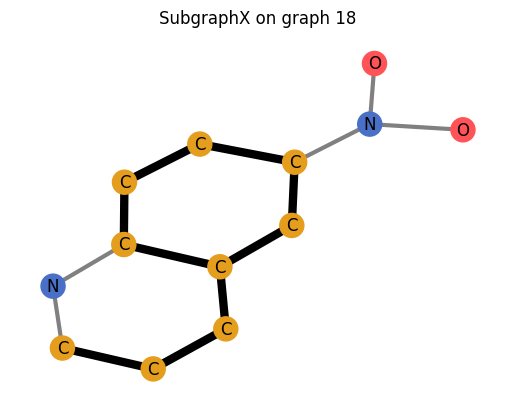

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


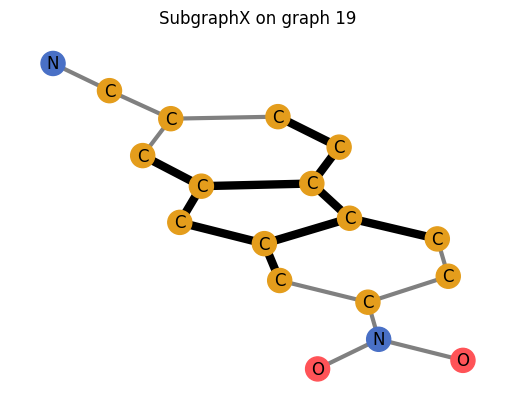

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


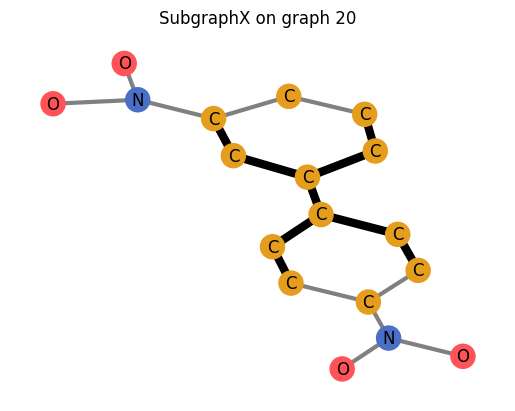

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


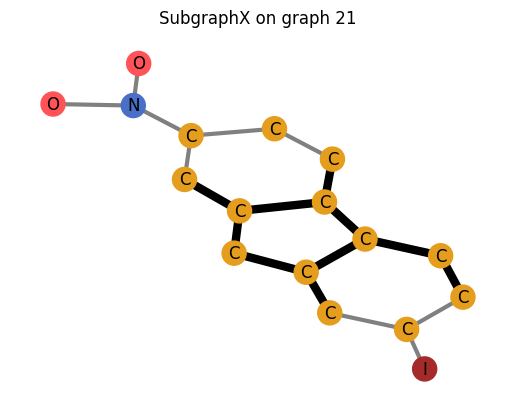

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


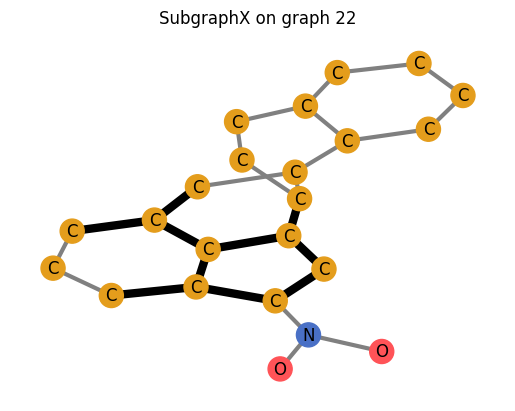

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


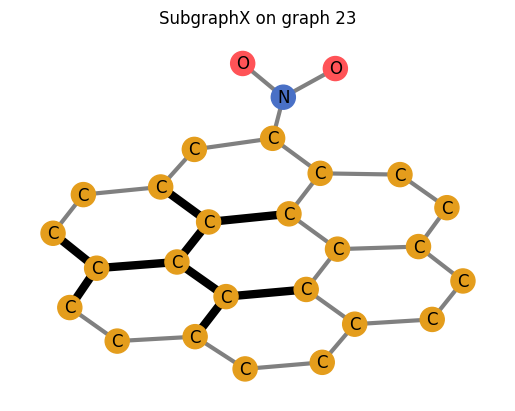

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


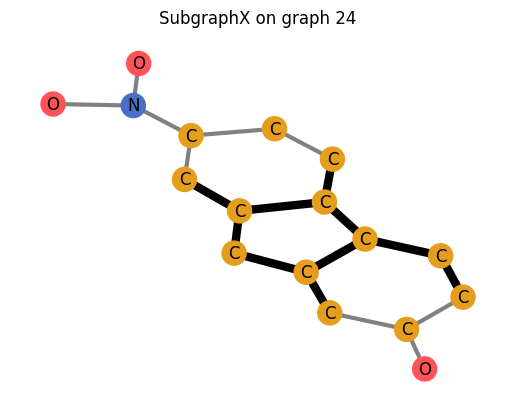

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


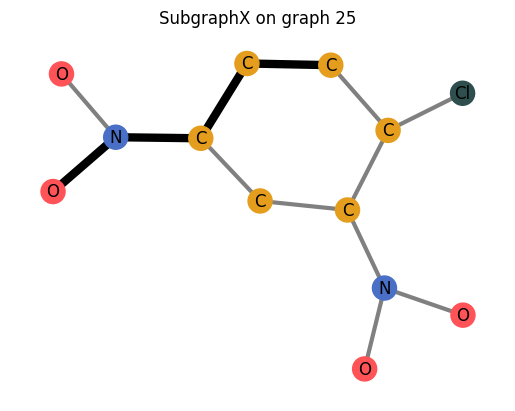

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


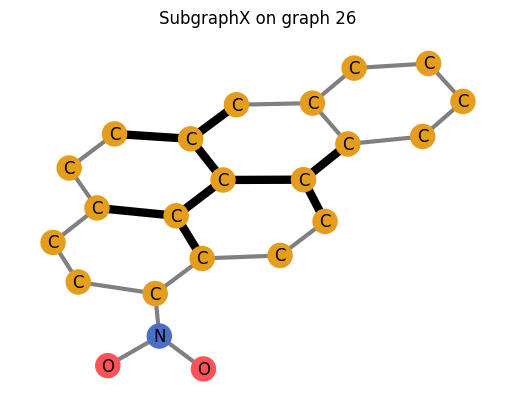

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


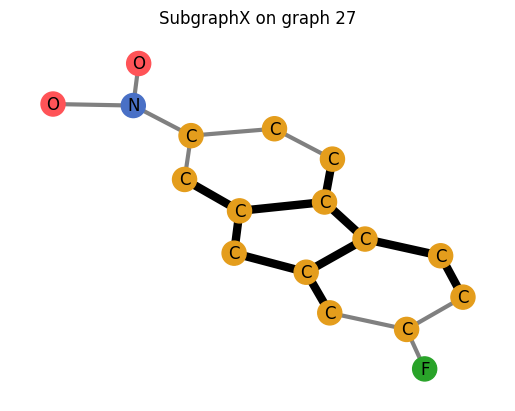

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


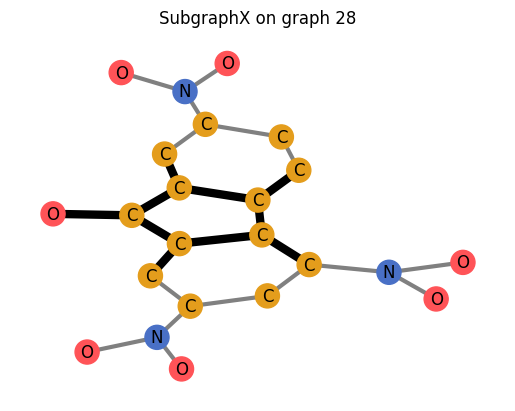

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


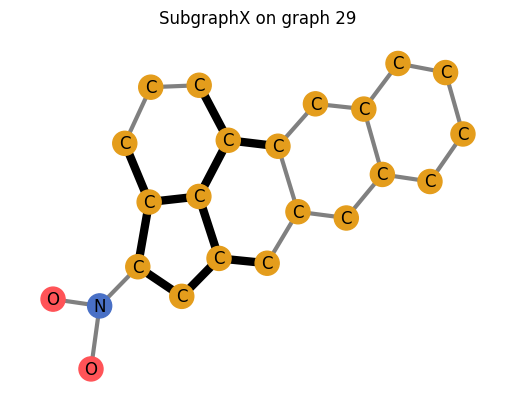

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


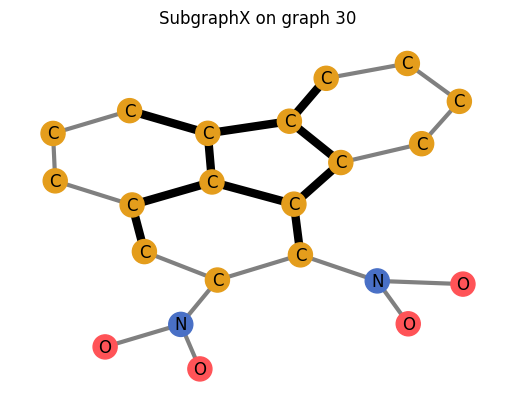

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


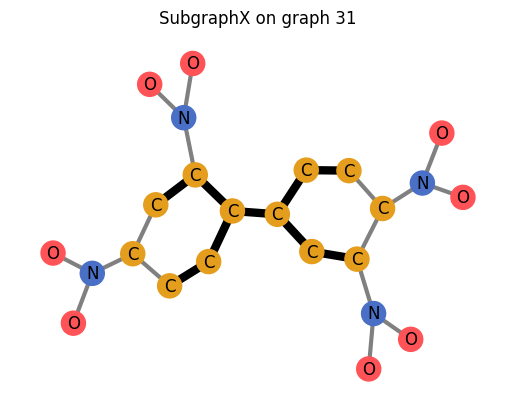

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


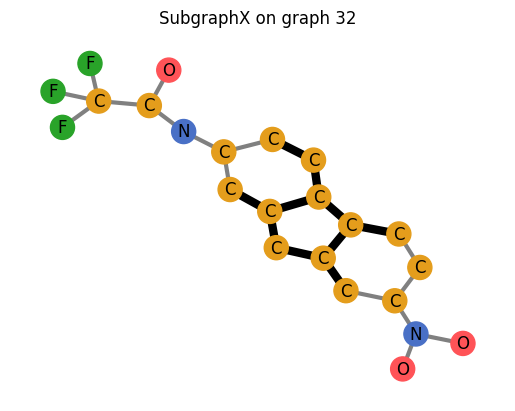

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


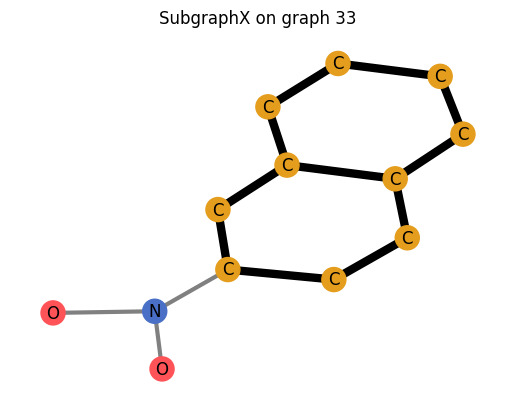

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


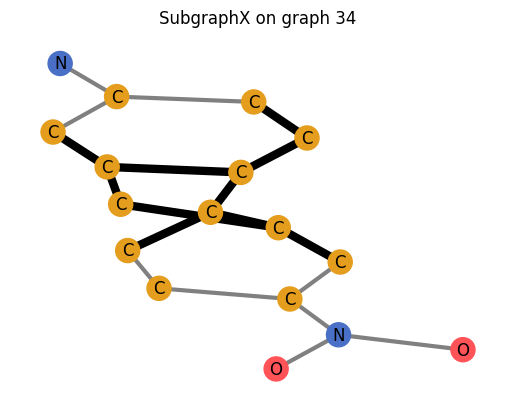

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


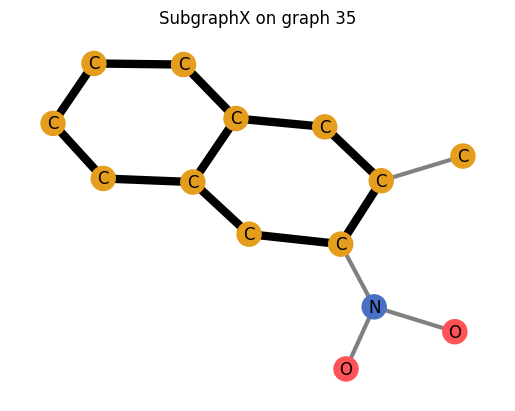

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


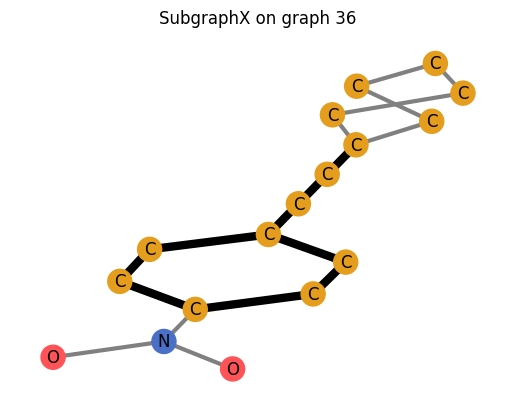

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


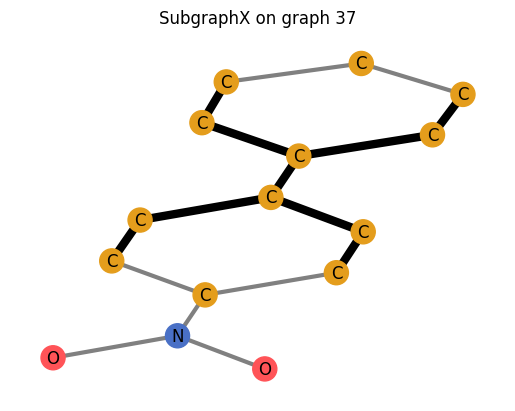

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


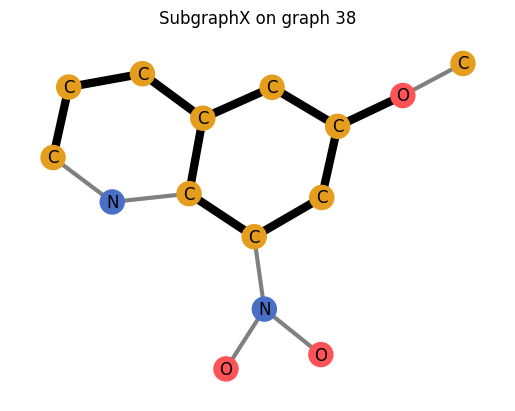

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


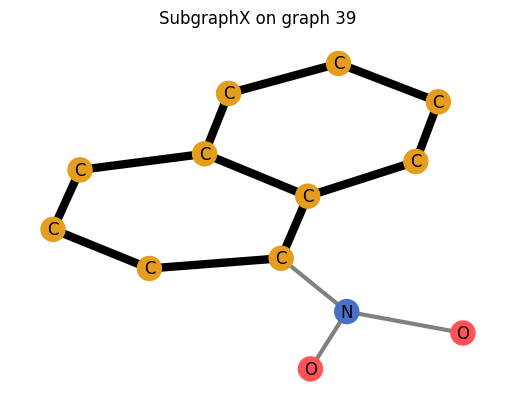

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


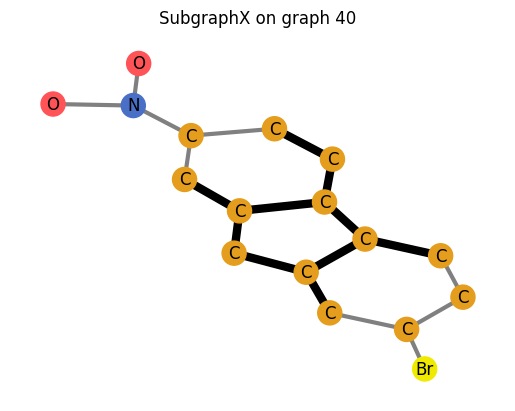

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


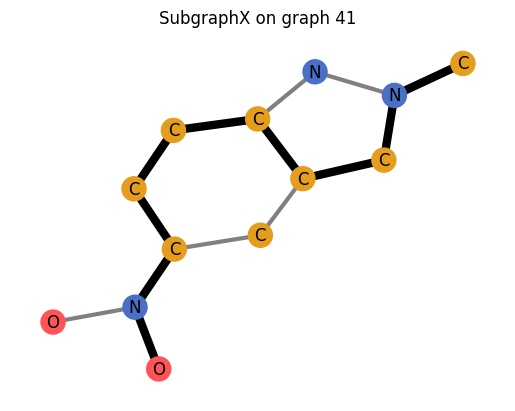

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


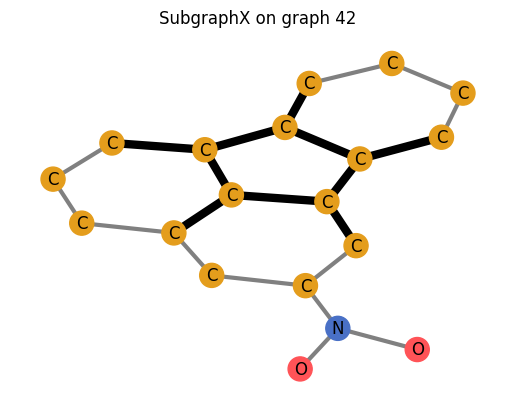

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


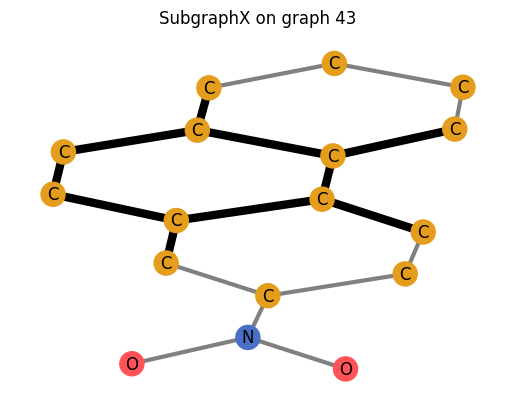

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


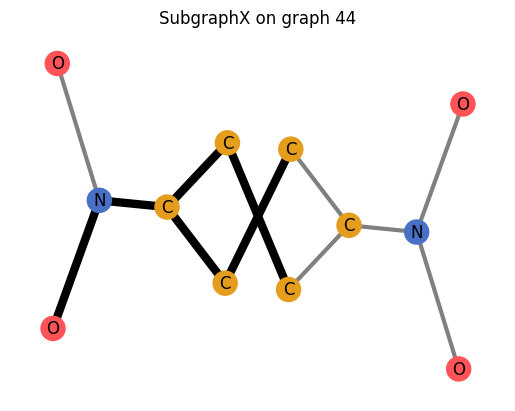

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


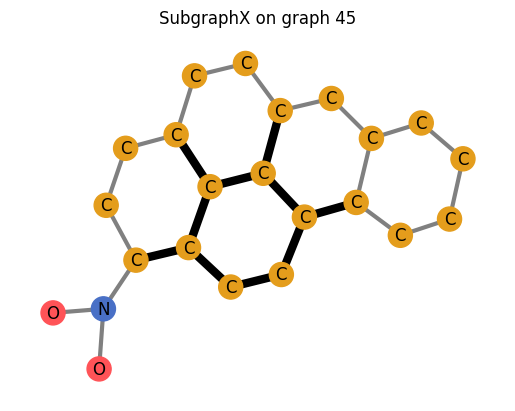

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


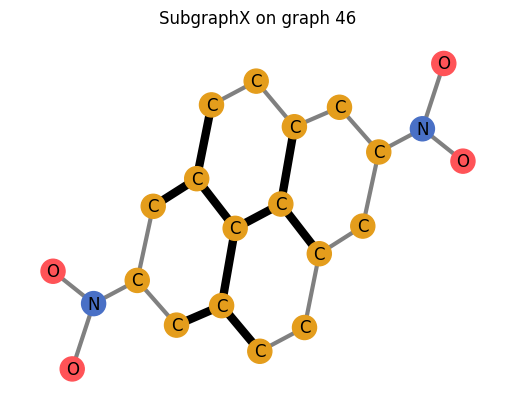

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


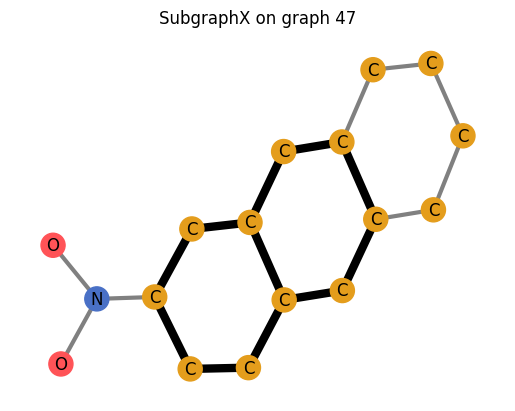

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


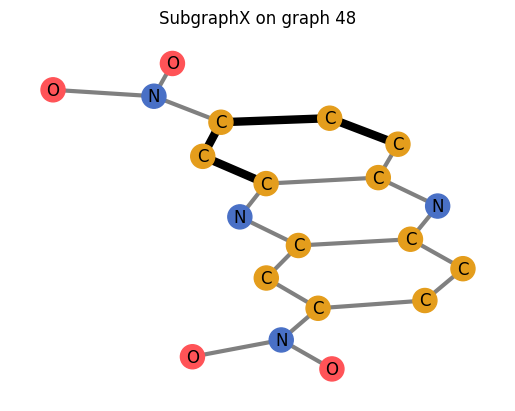

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   1


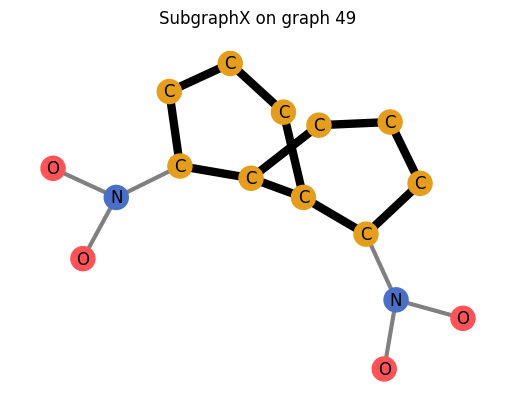

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


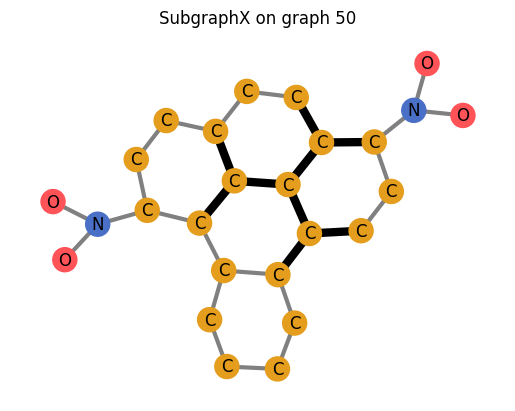

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


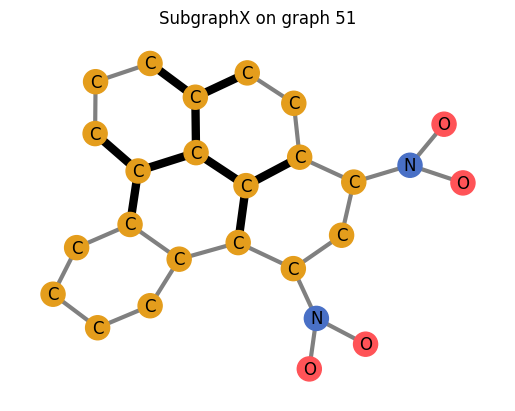

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


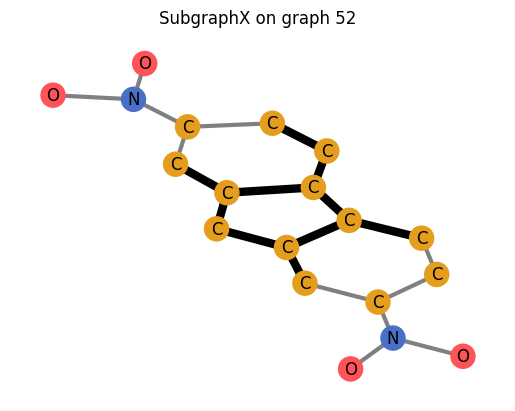

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


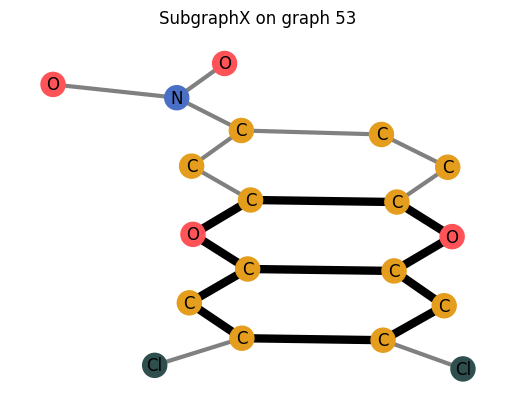

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


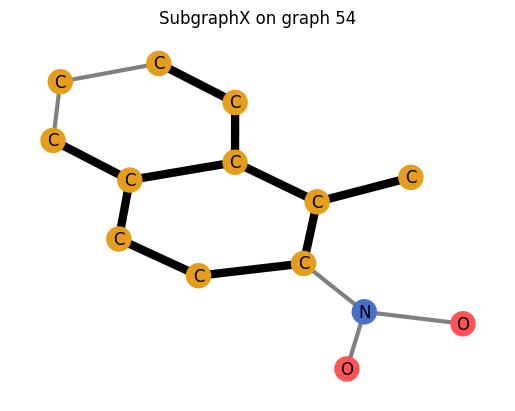

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


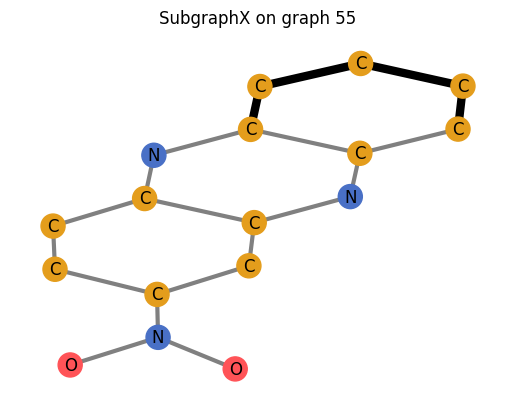

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


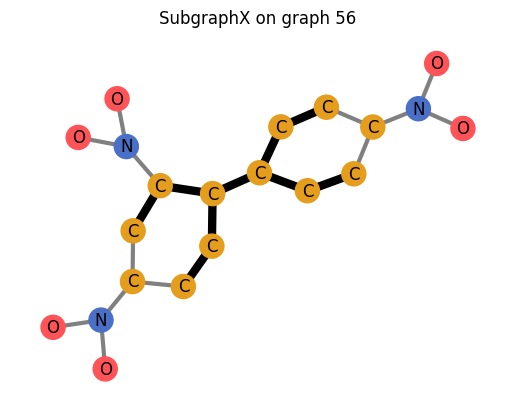

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


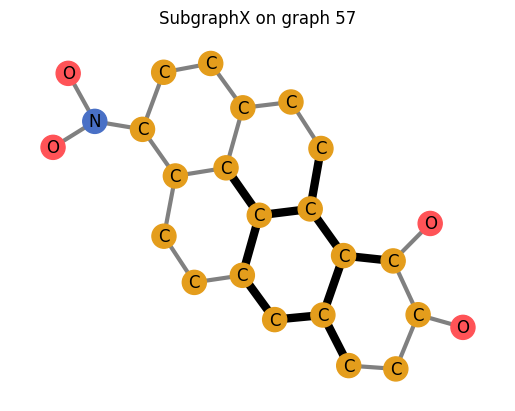

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


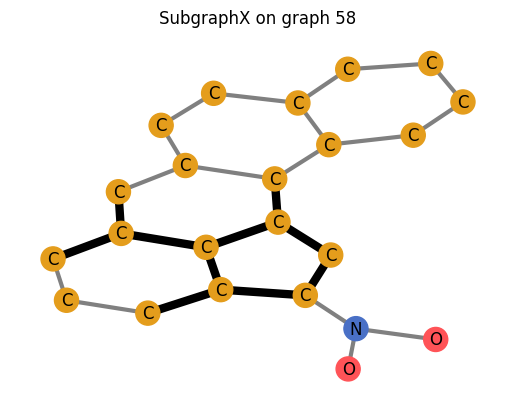

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


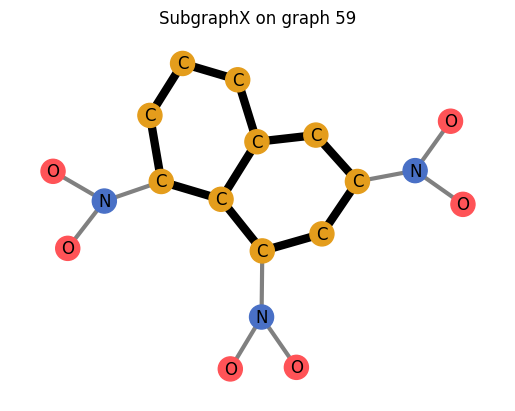

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


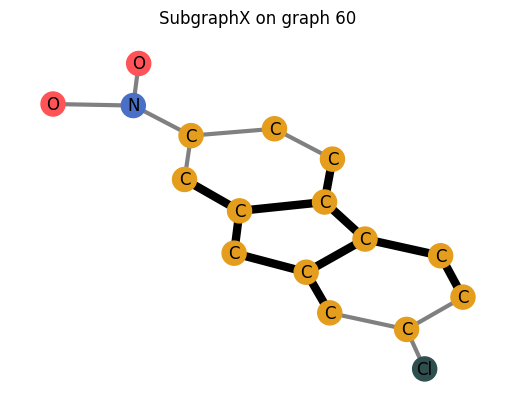

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


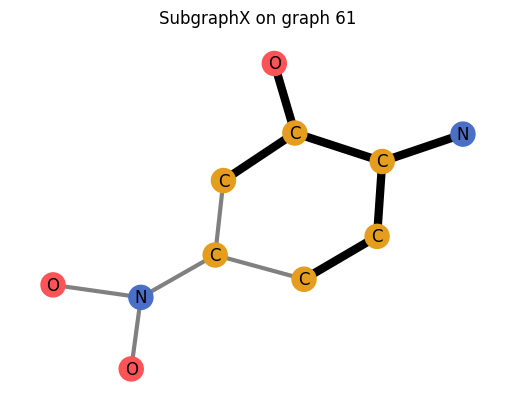

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


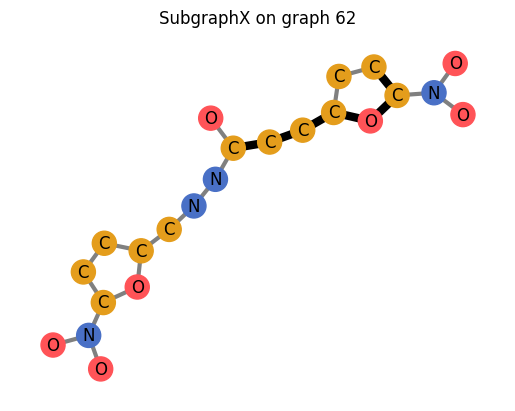

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


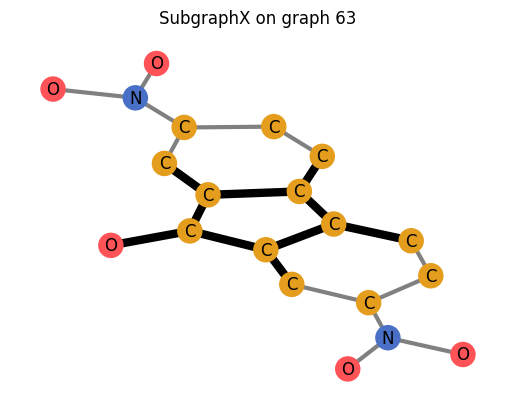

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


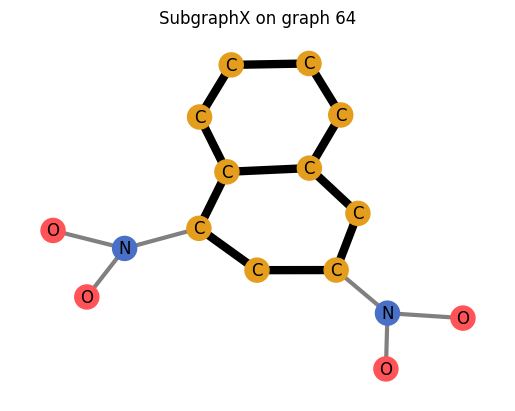

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


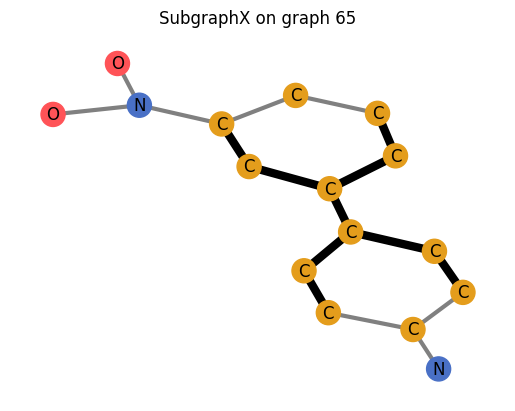

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


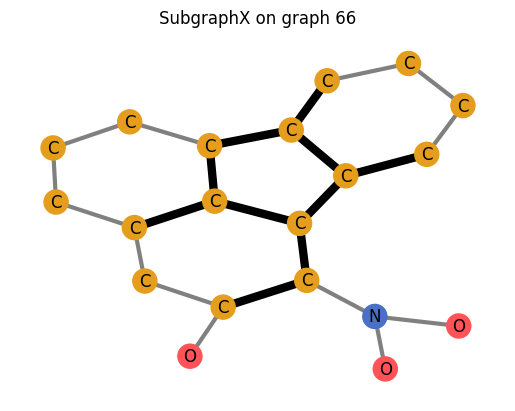

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


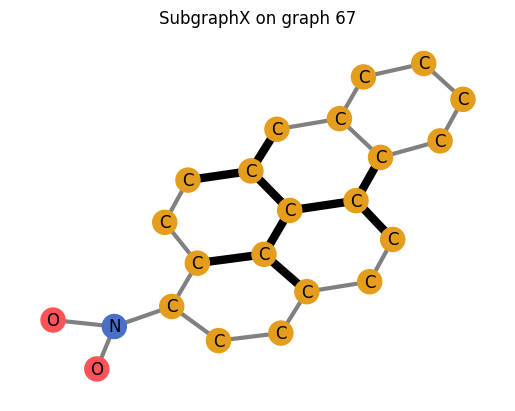

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


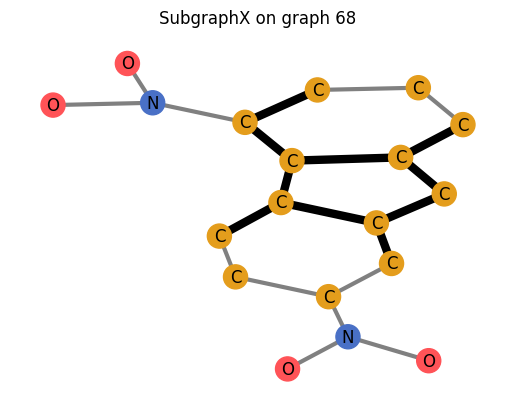

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


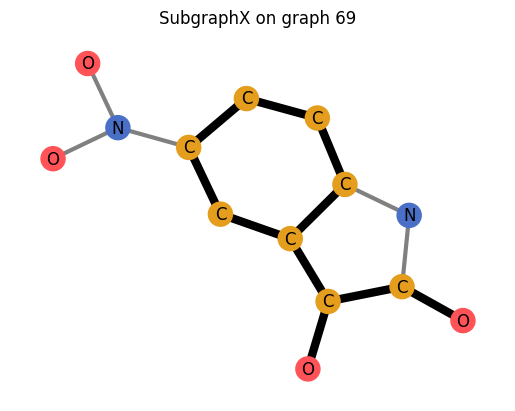

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


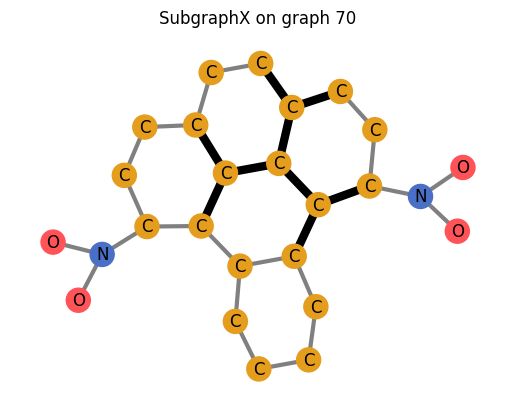

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


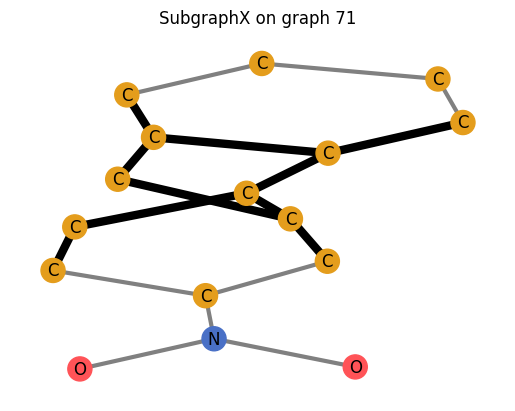

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


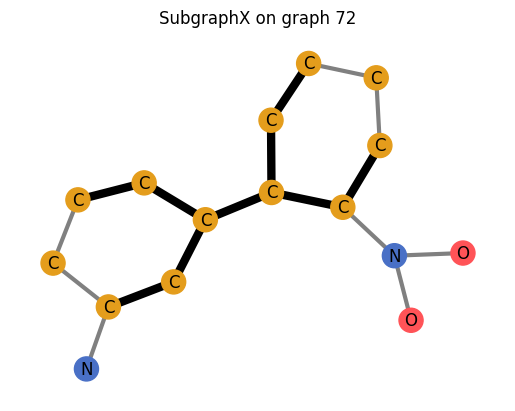

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


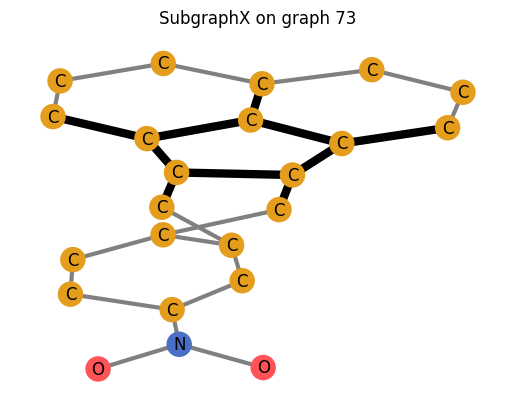

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


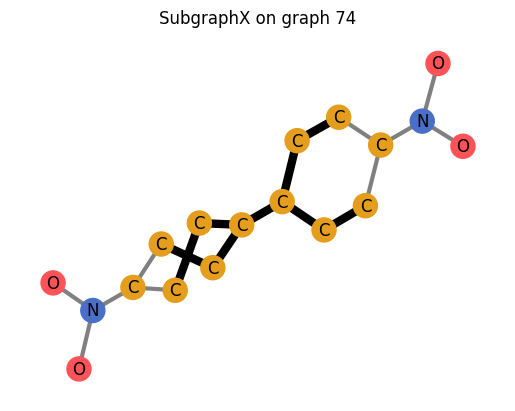

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


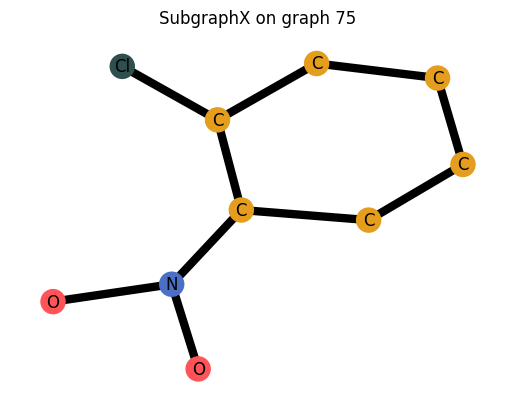

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


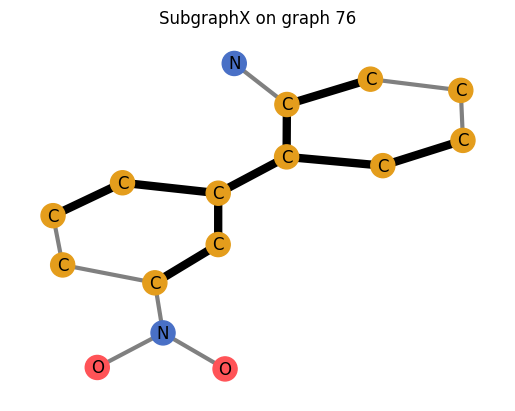

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


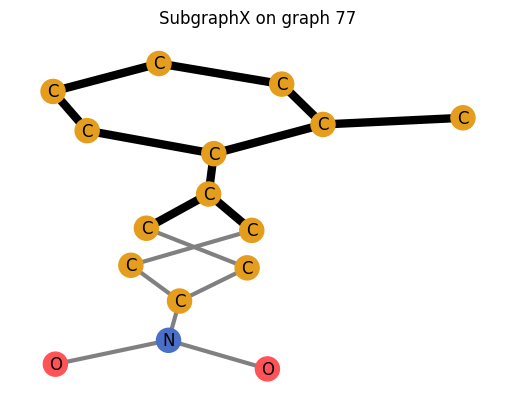

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


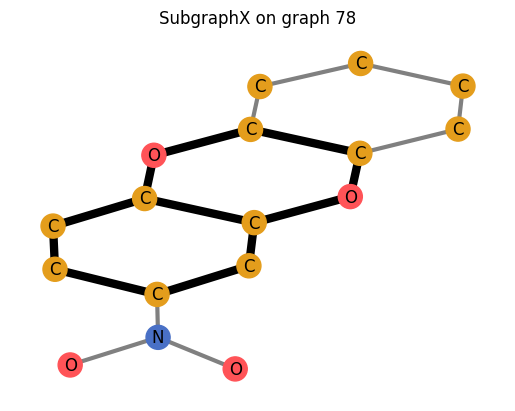

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


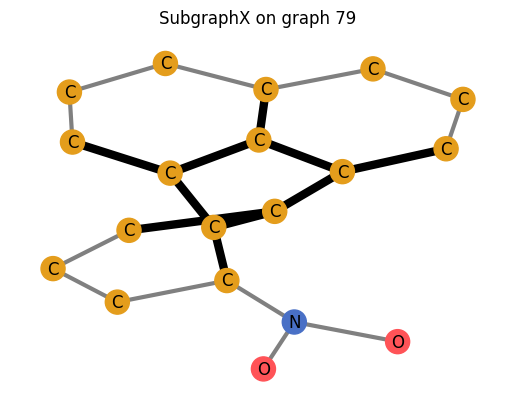

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


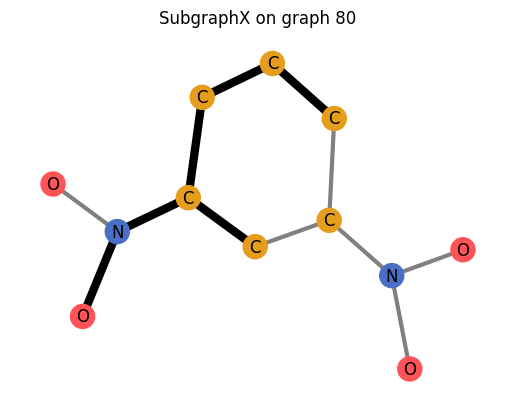

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


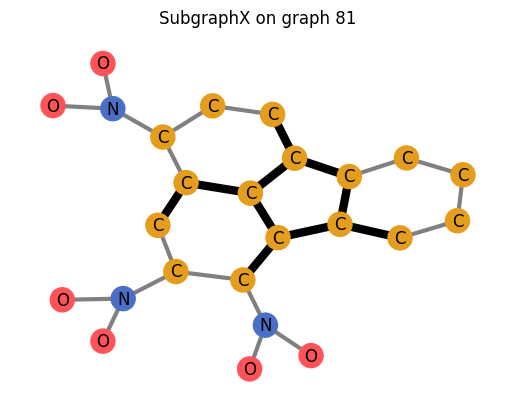

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   1


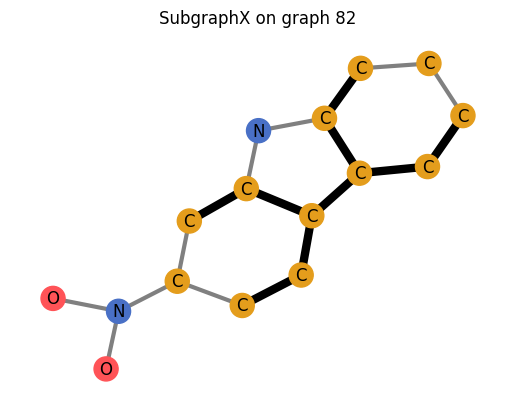

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


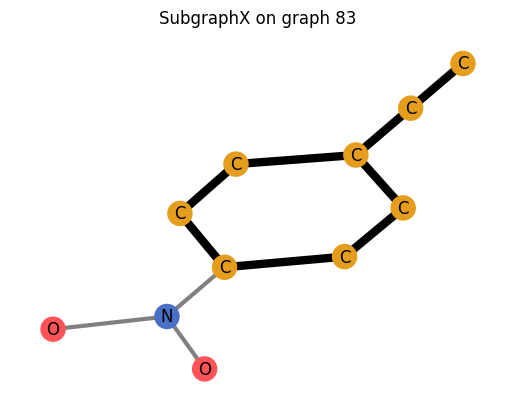

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


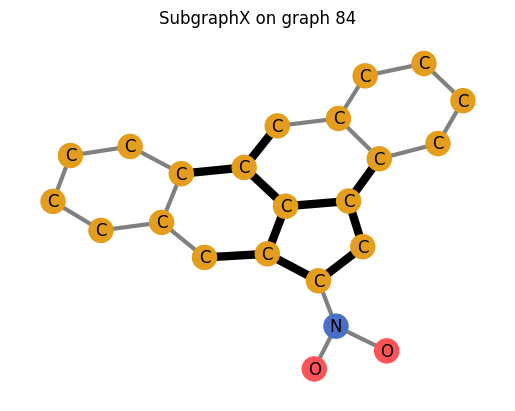

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


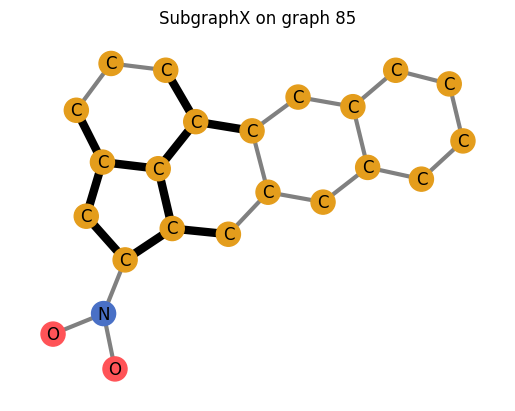

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


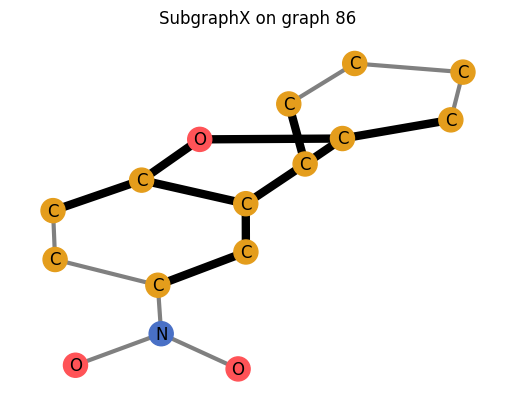

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


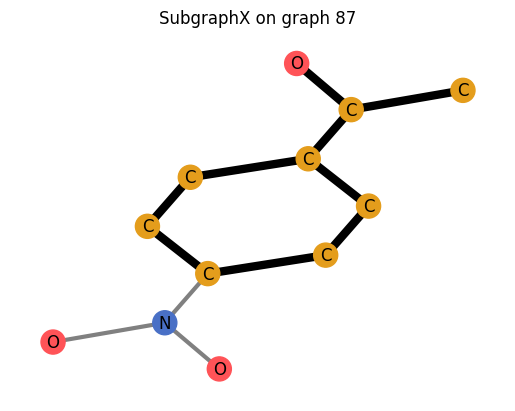

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


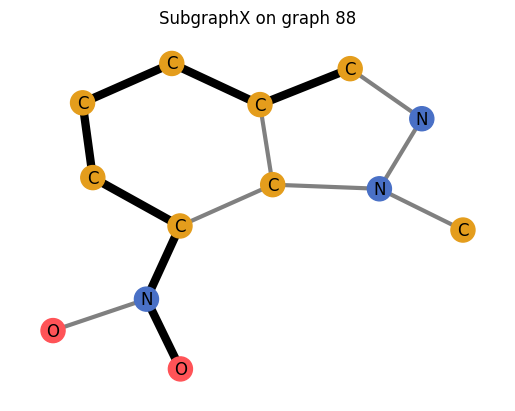

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


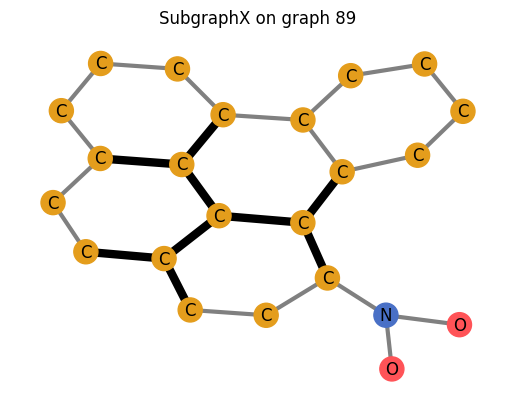

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


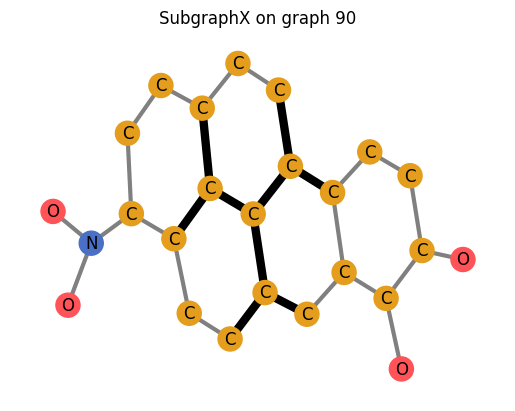

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


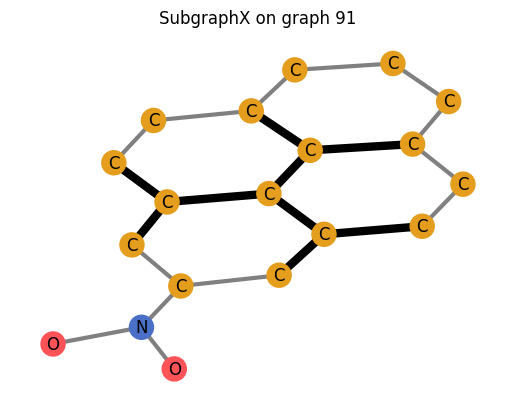

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


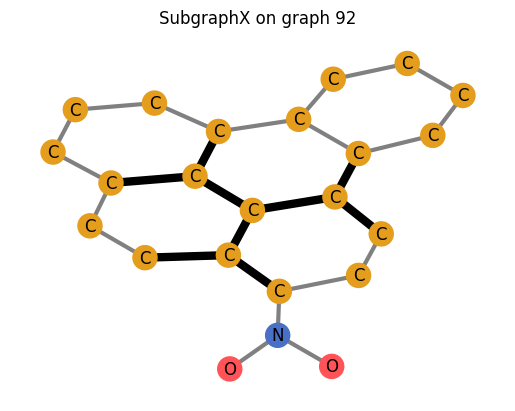

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


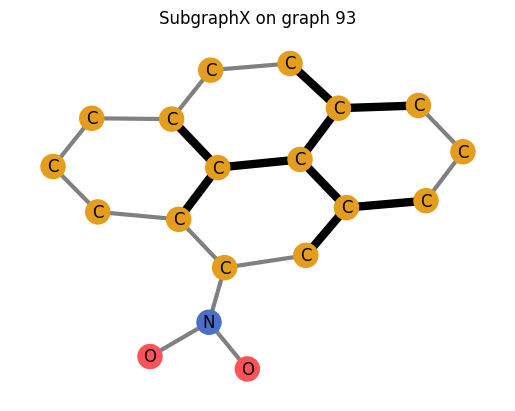

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


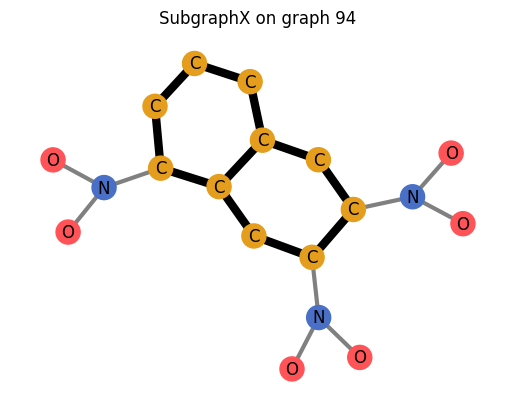

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


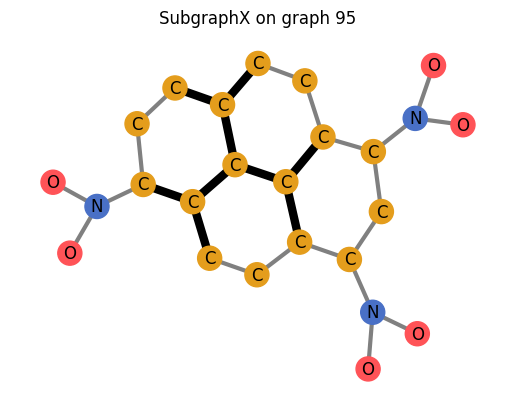

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


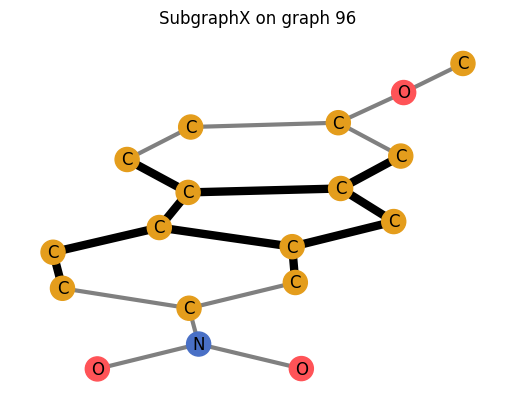

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


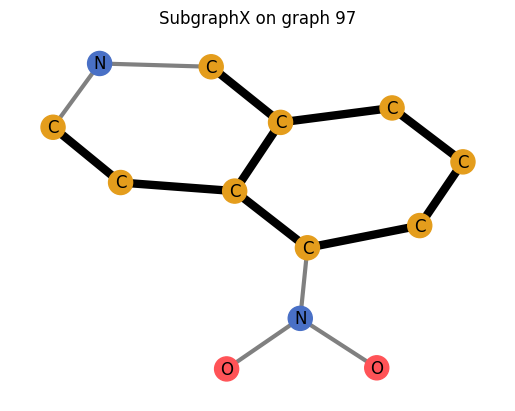

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


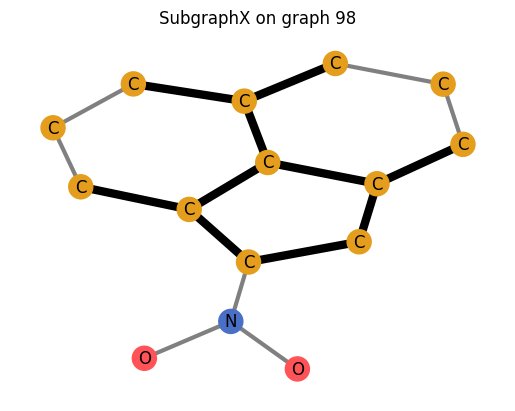

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


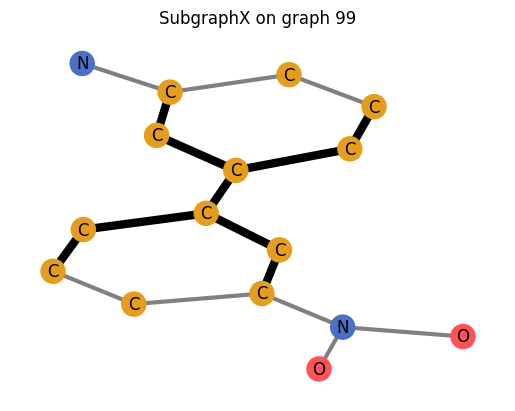

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


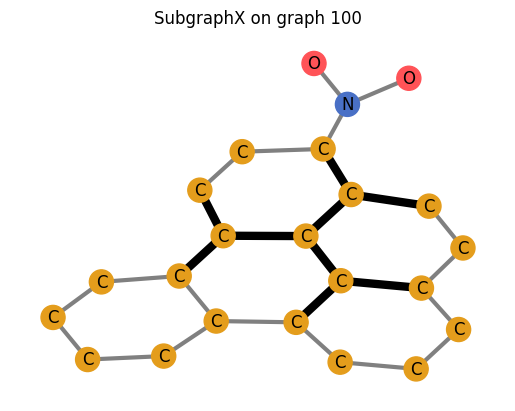

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


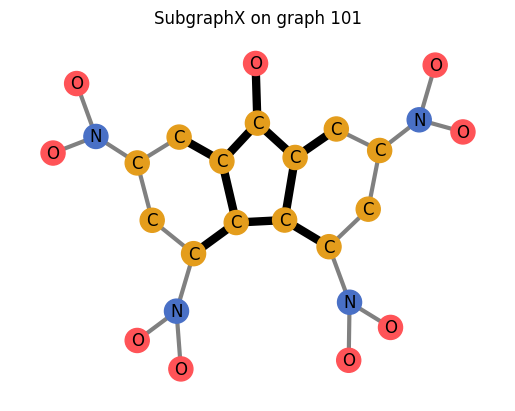

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


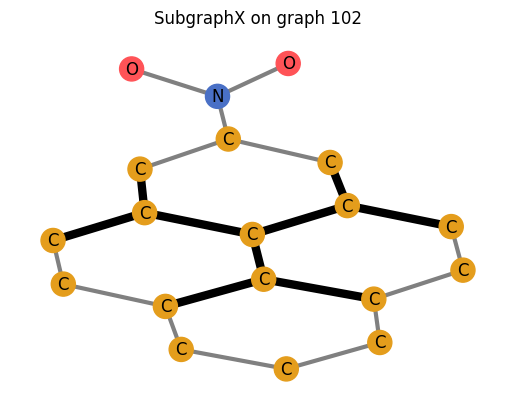

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


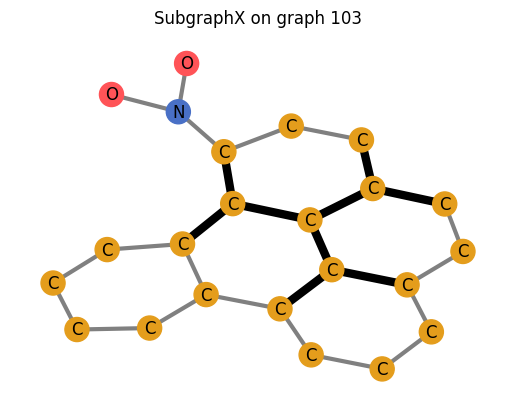

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


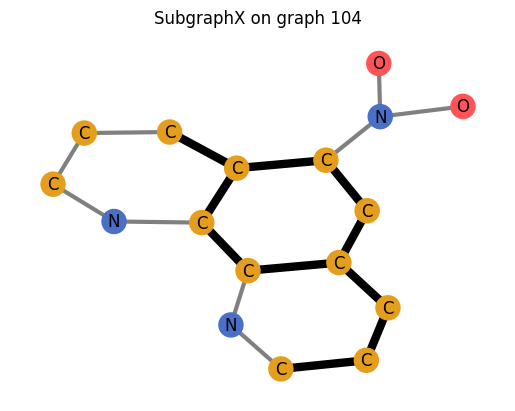

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


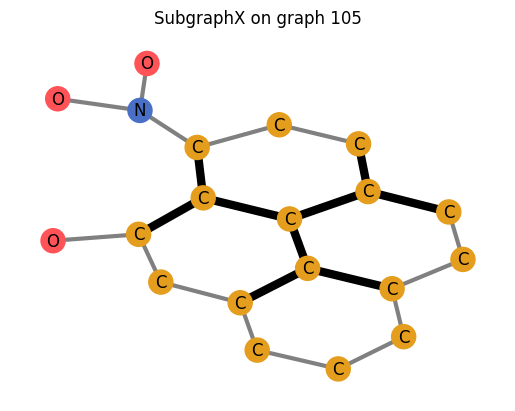

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


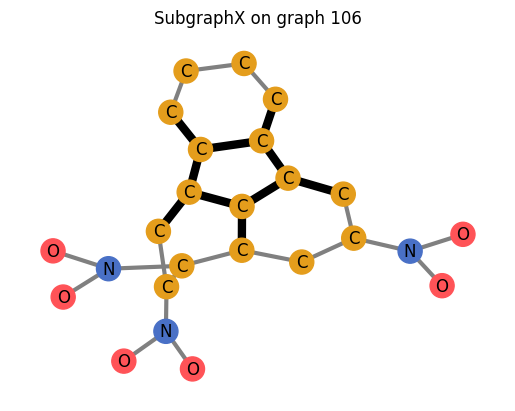

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


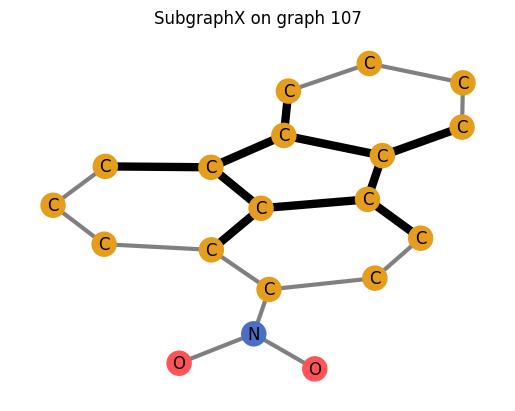

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


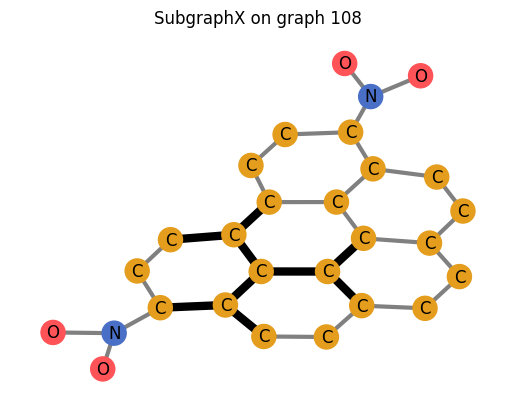

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   1


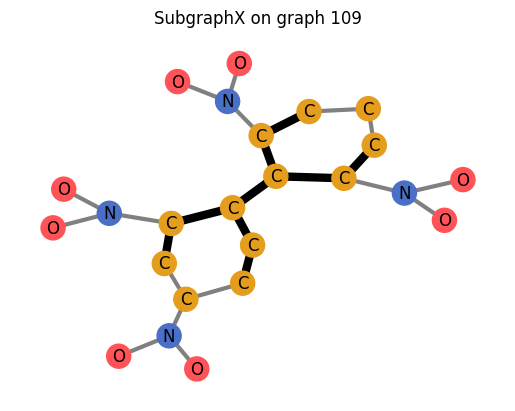

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


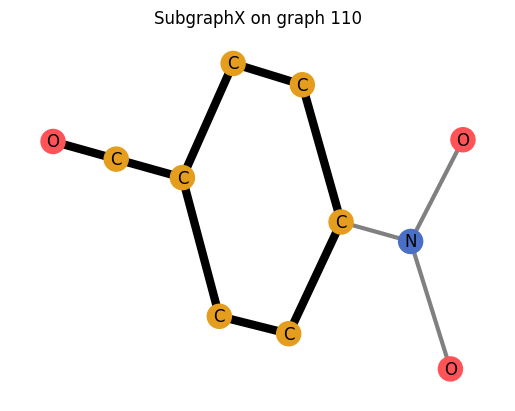

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


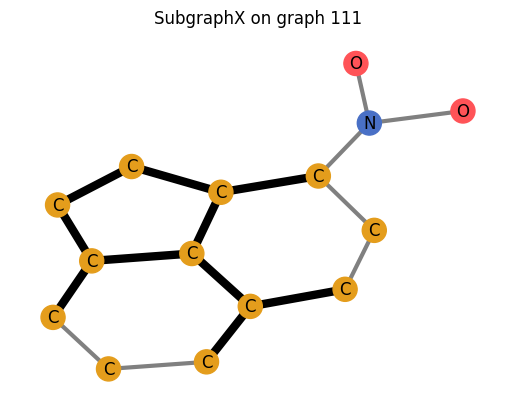

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


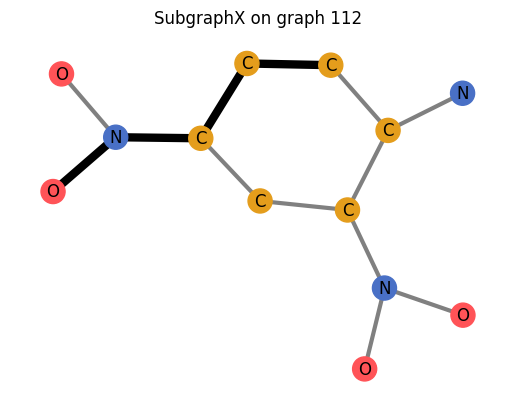

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


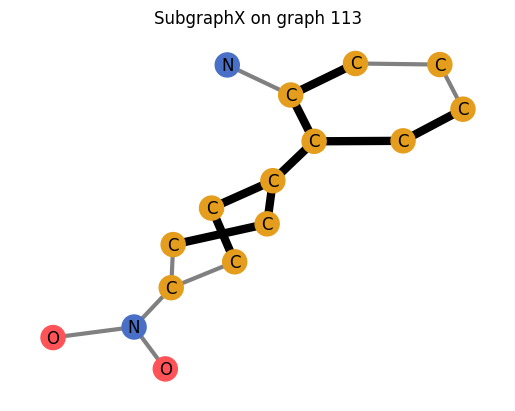

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


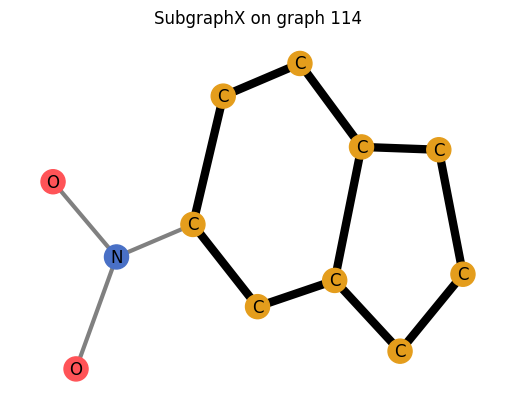

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


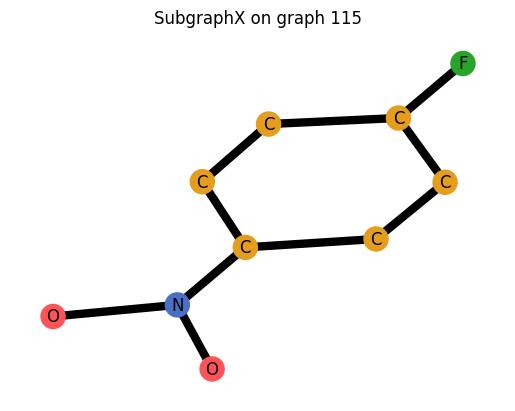

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


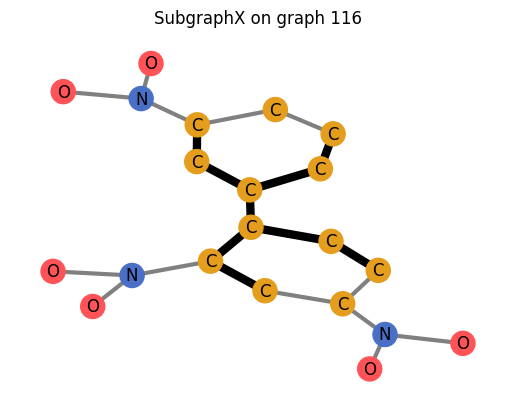

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


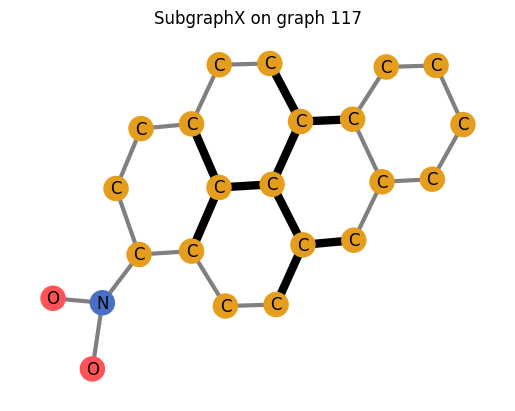

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   1


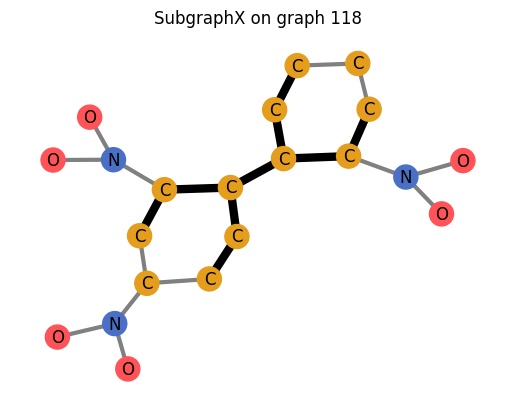

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


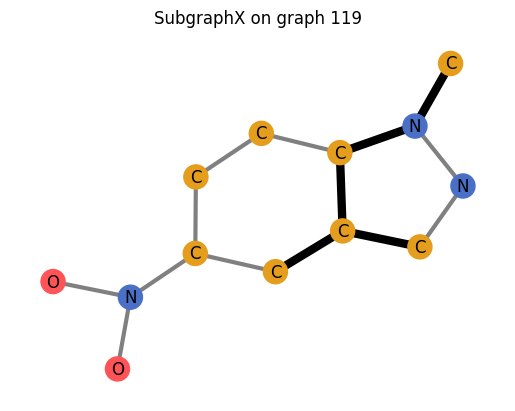

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


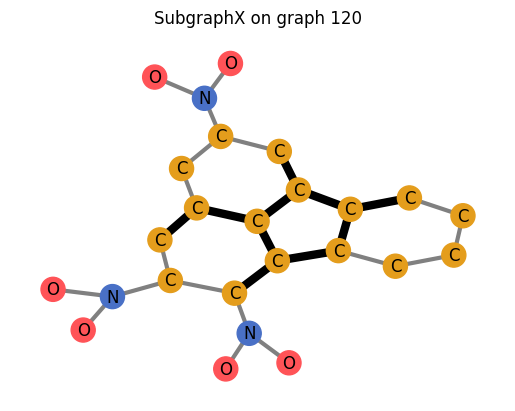

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


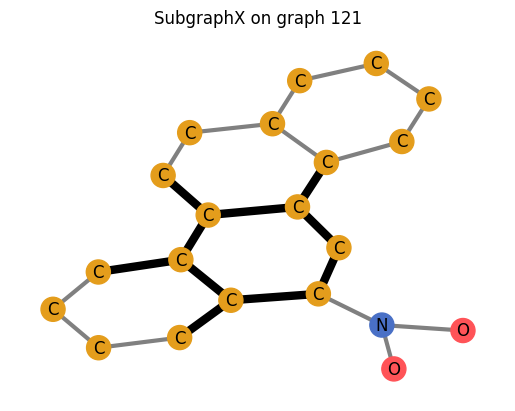

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


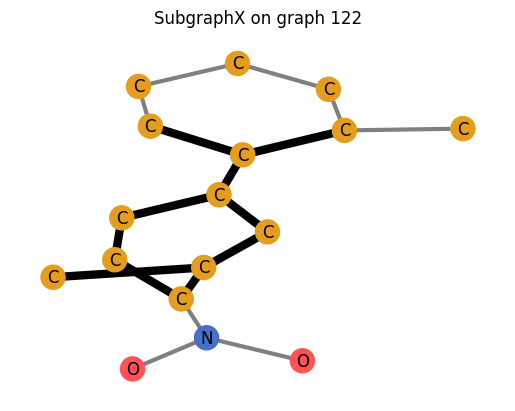

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


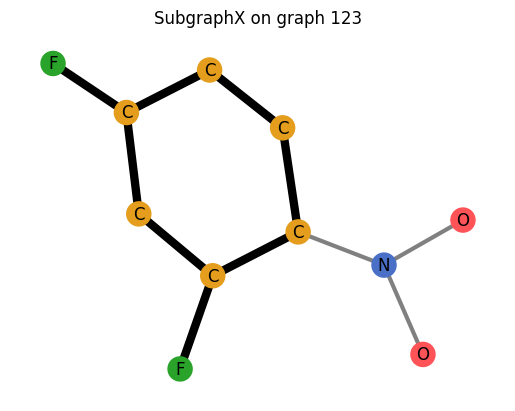

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


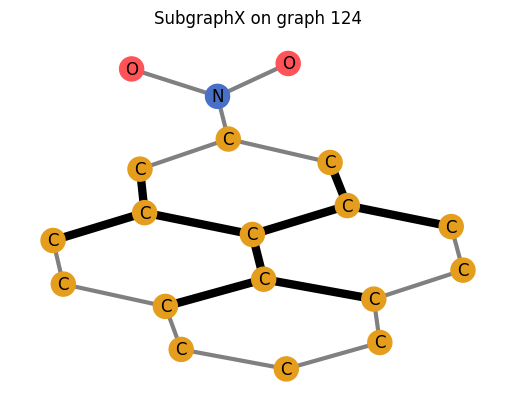

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


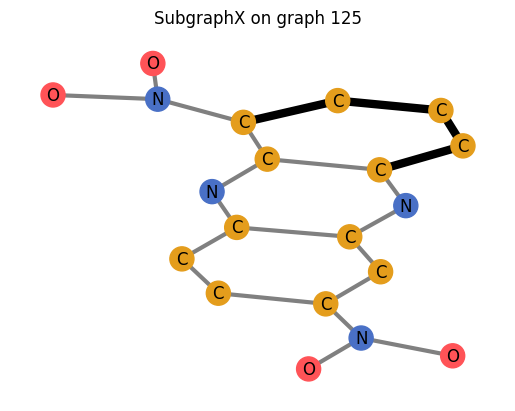

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


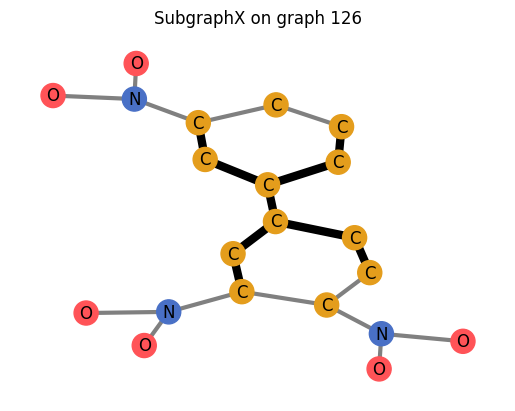

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


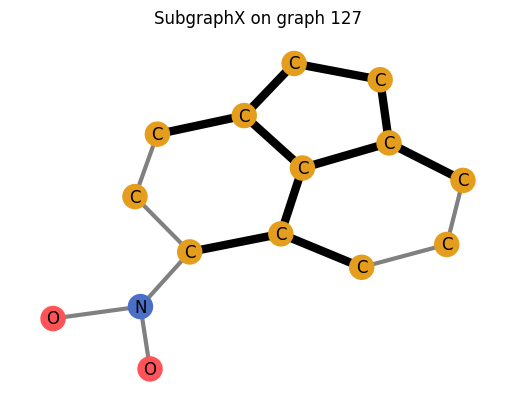

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


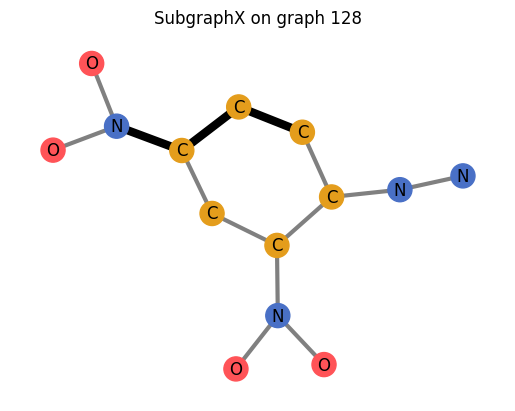

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


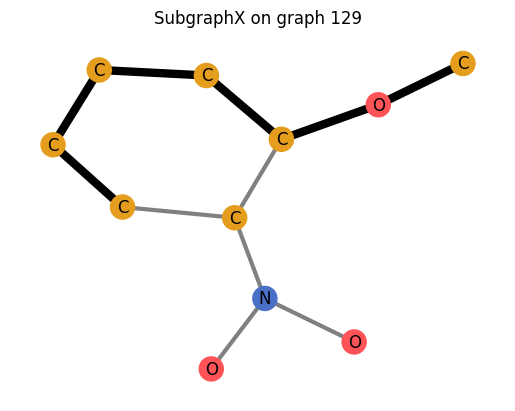

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


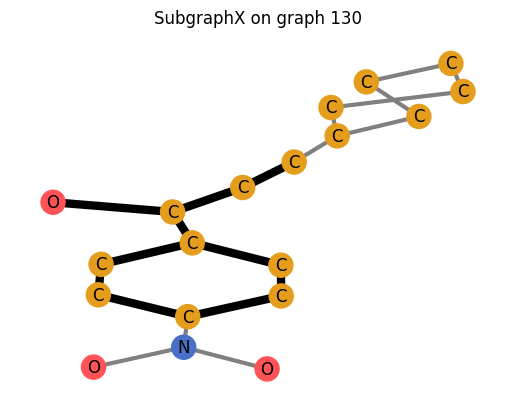

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


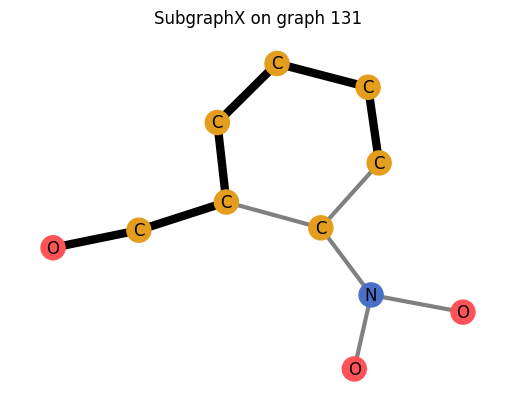

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


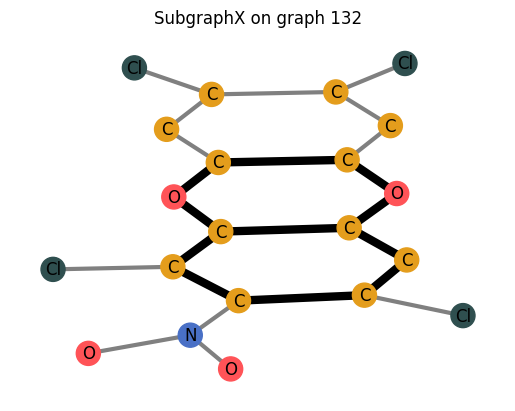

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


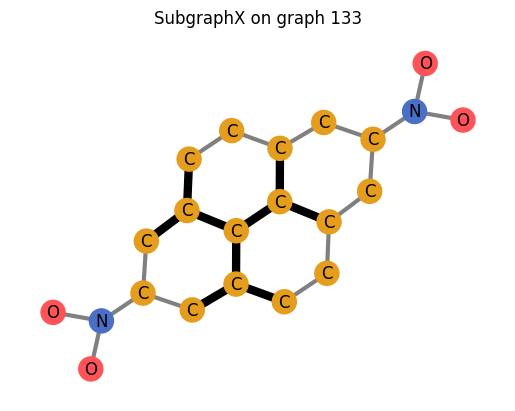

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


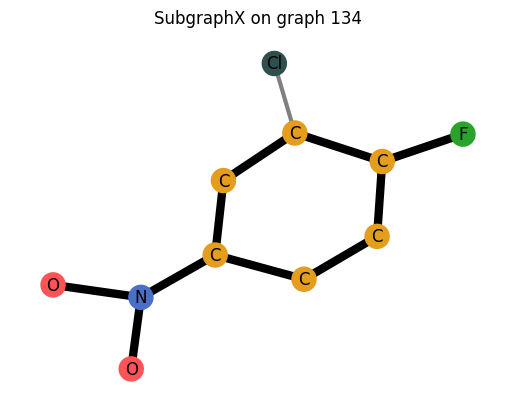

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


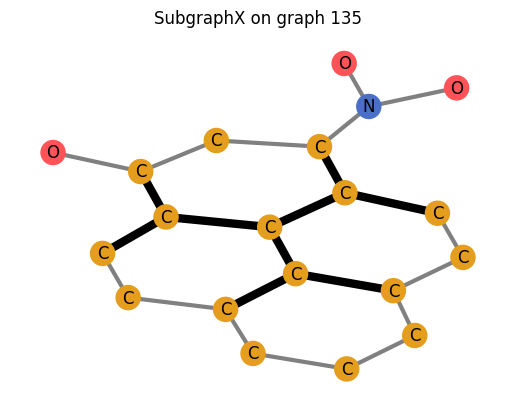

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


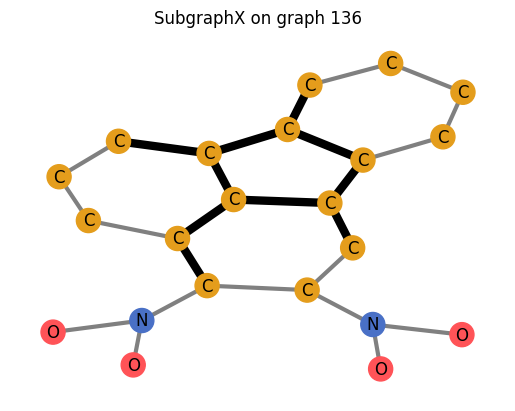

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


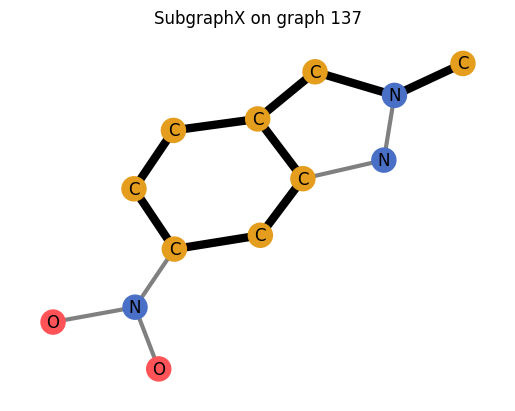

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


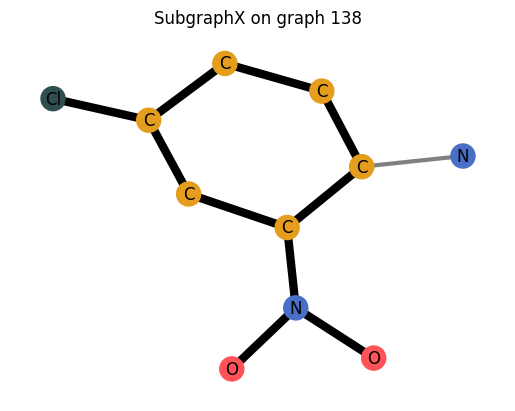

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


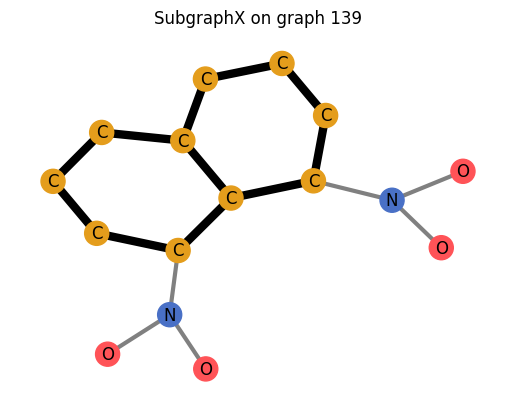

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


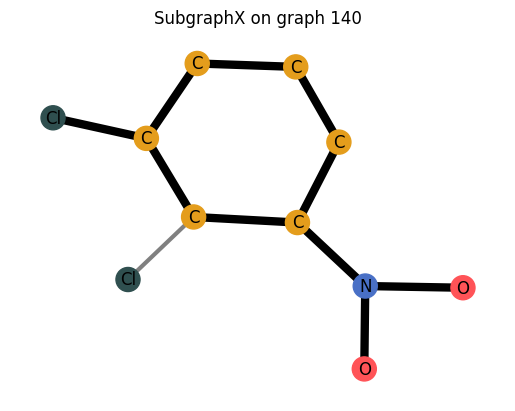

  0%|          | 0/20 [00:00<?, ?it/s]

0   1   1


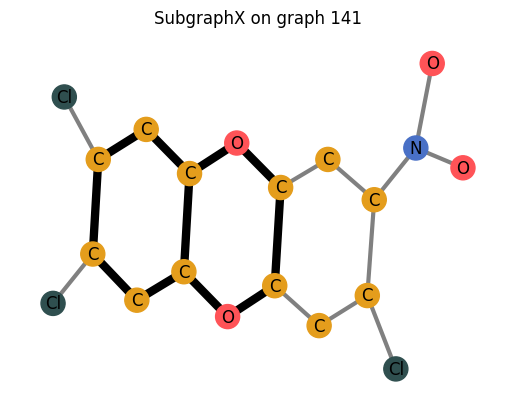

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


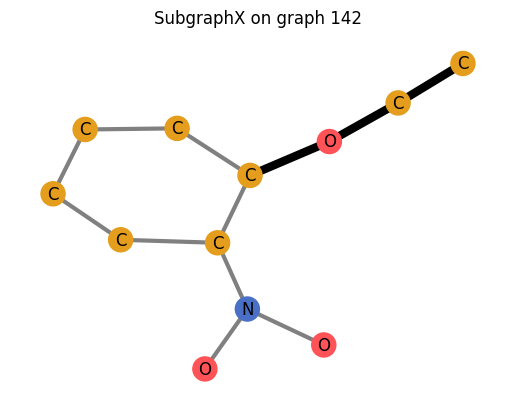

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


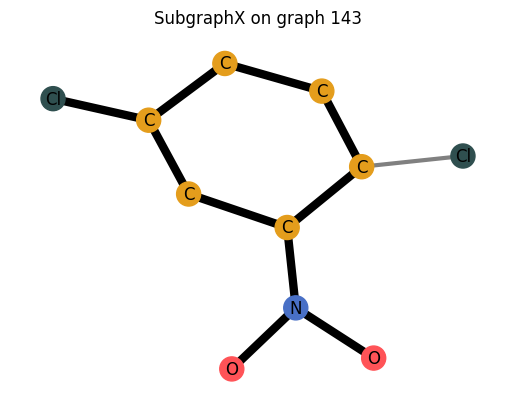

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


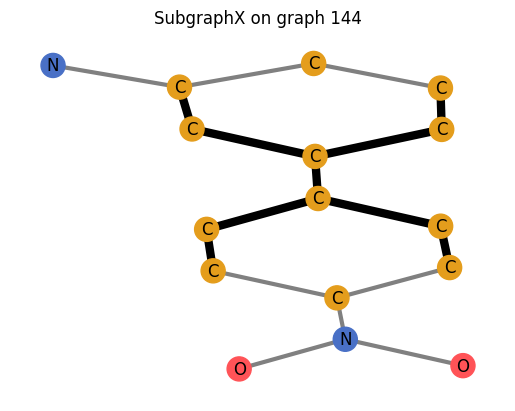

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


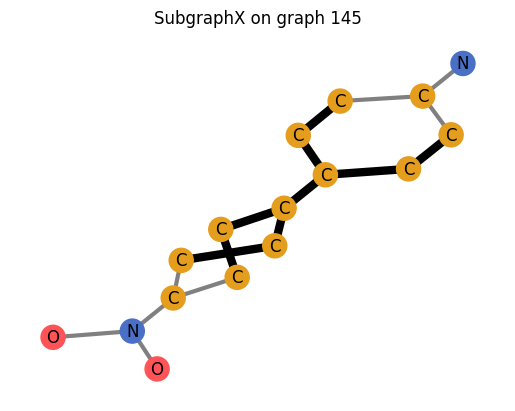

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


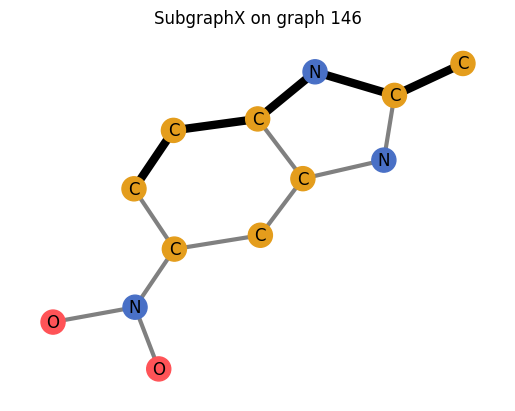

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


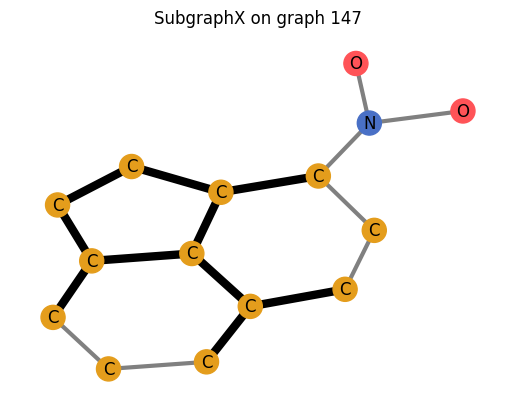

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


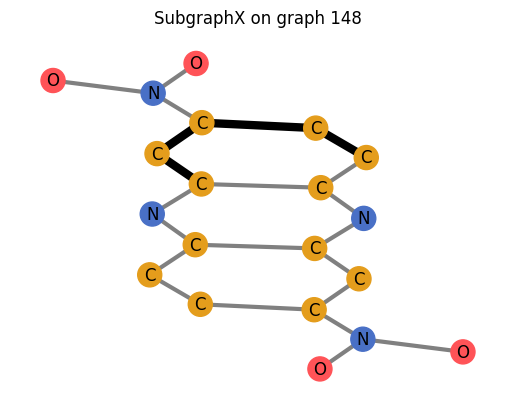

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


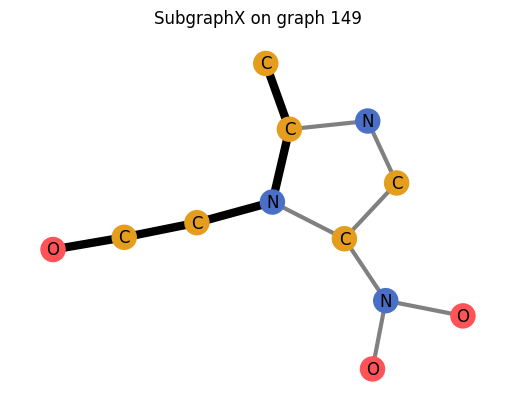

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


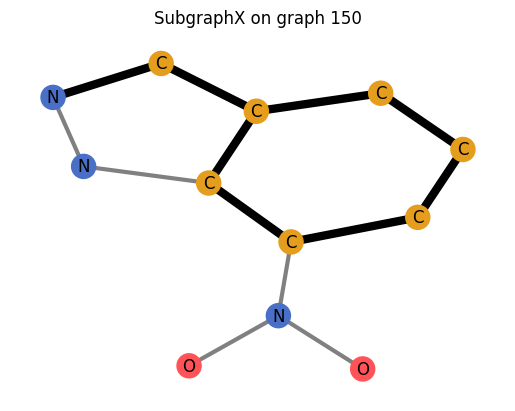

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


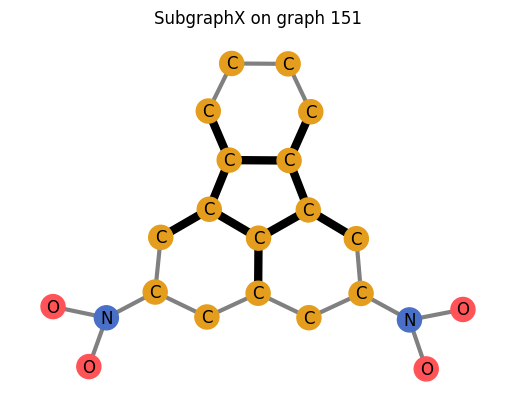

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


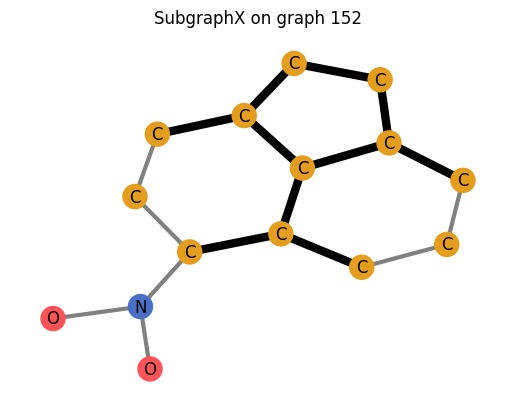

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


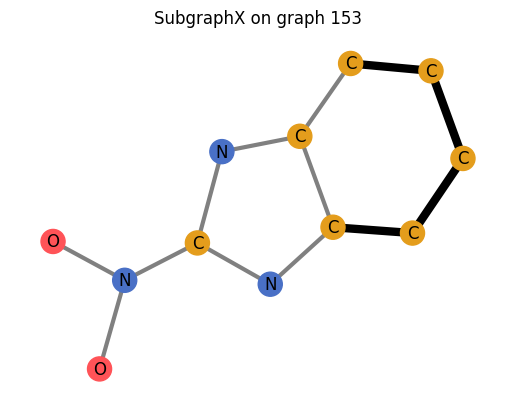

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


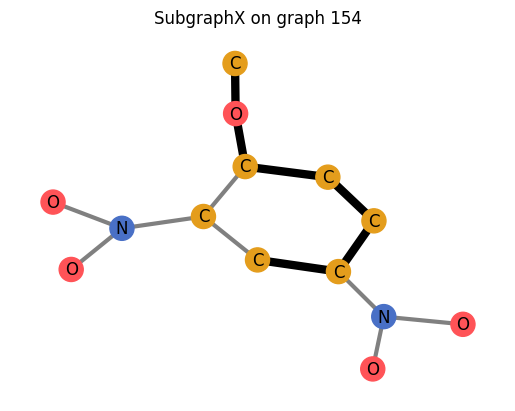

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


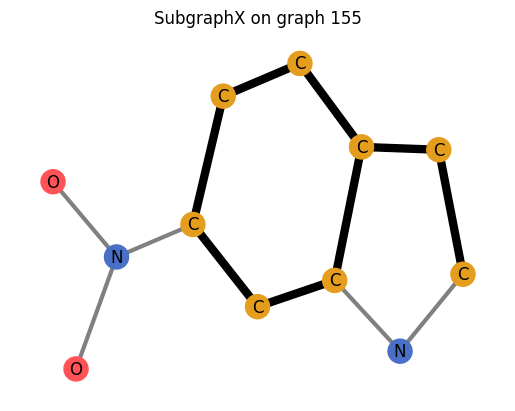

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


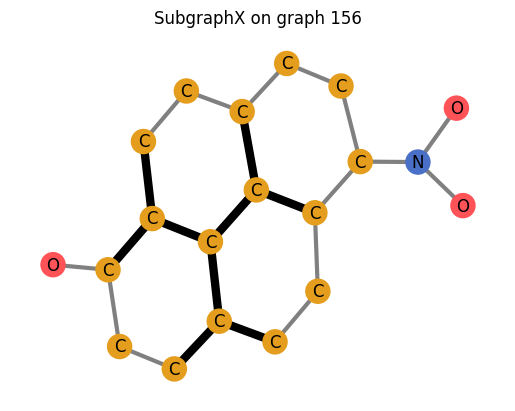

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


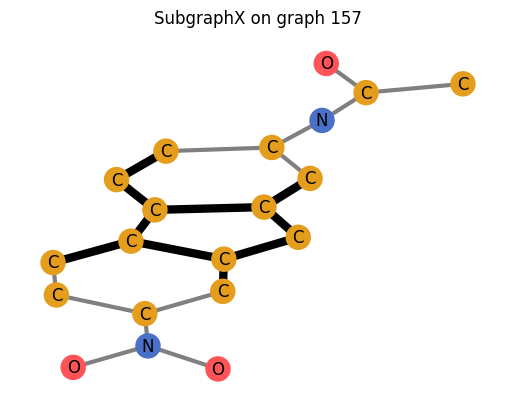

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


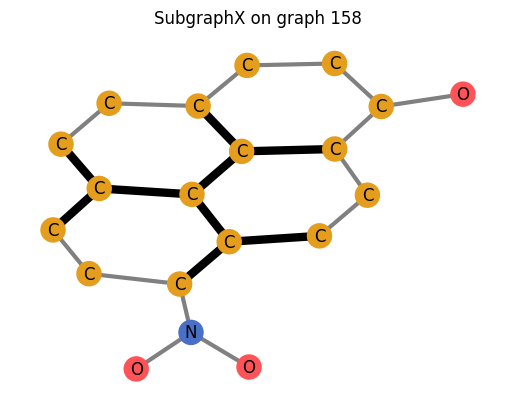

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


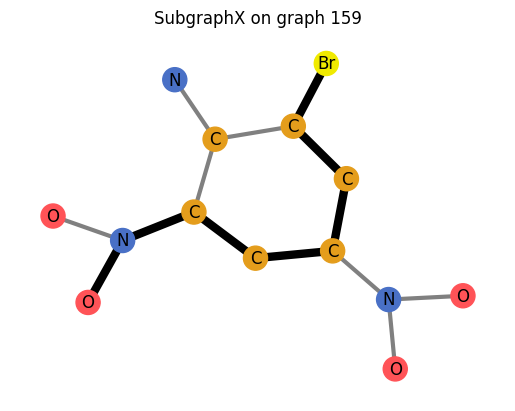

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


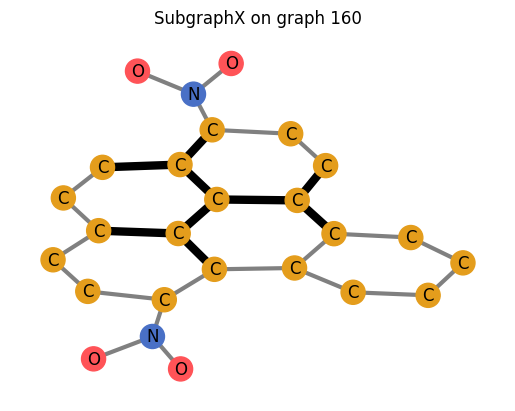

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


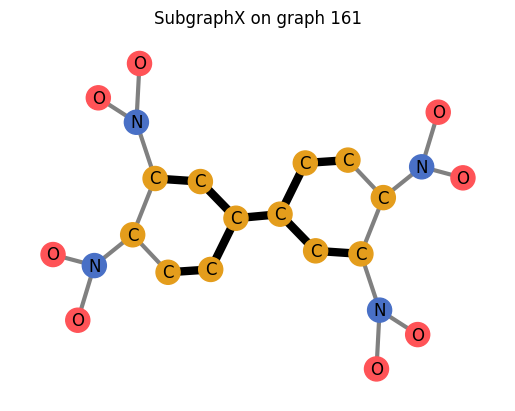

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


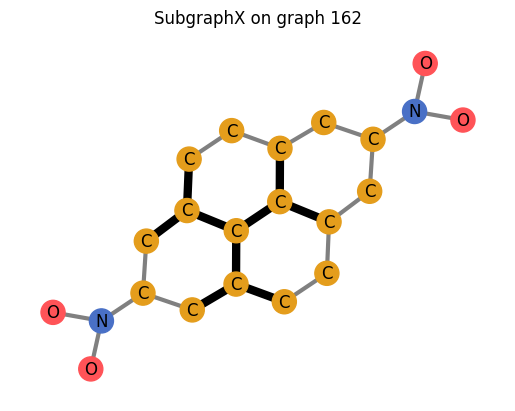

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


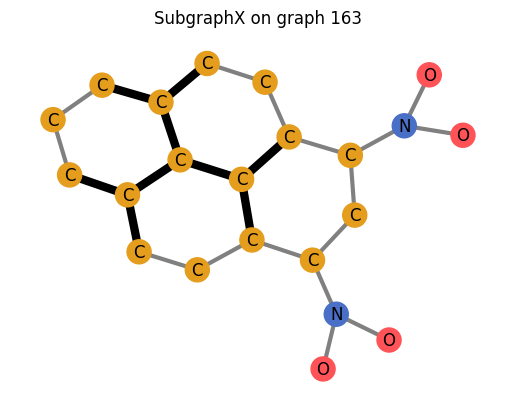

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


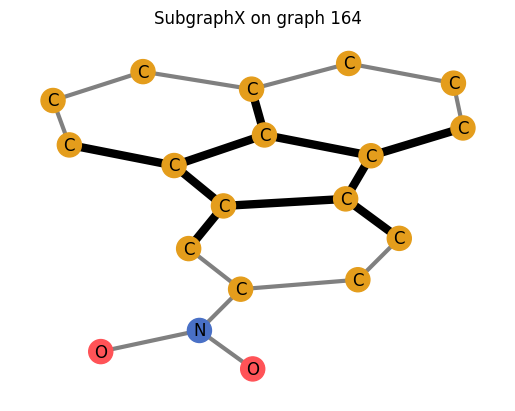

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


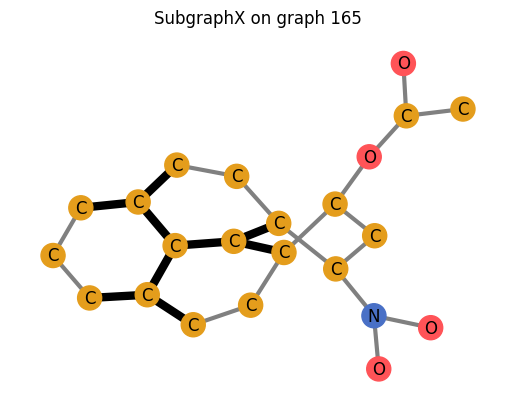

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


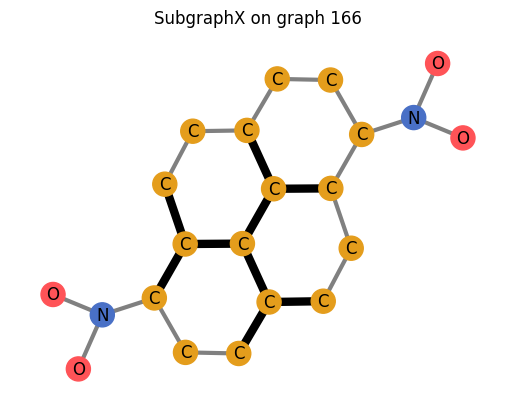

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


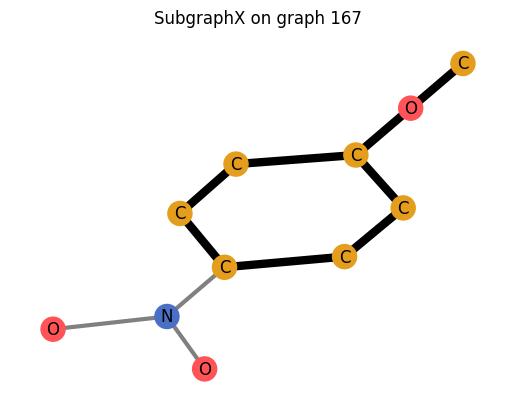

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


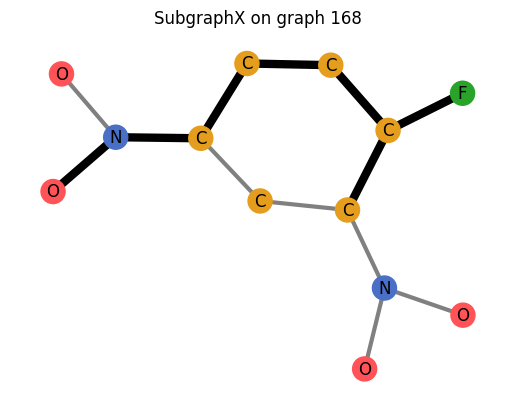

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


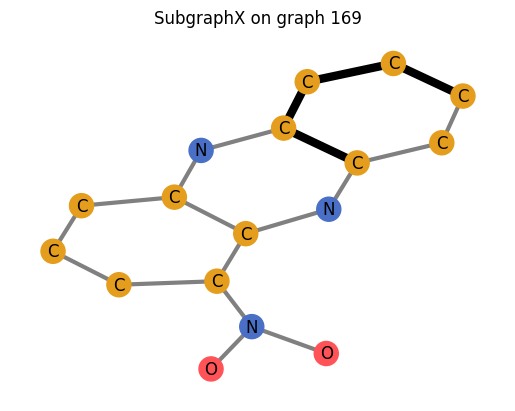

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   1


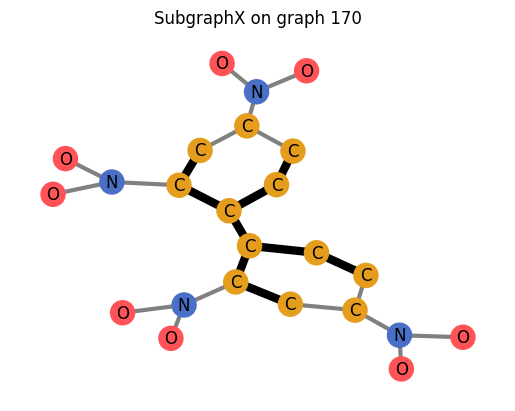

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


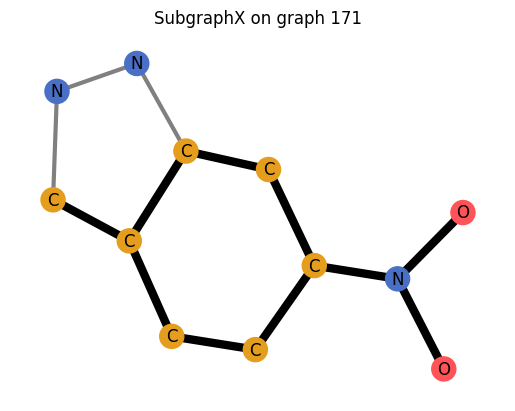

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


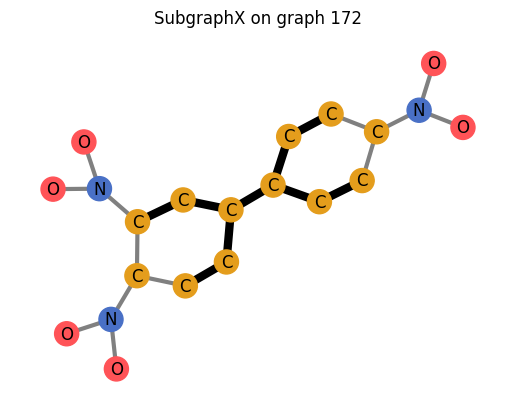

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


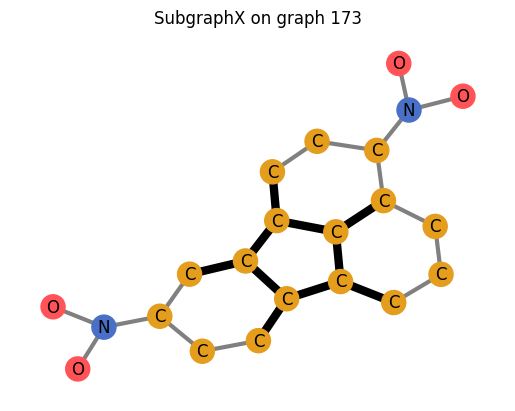

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   1


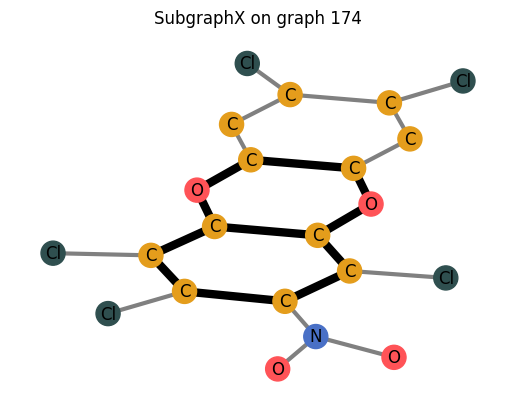

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


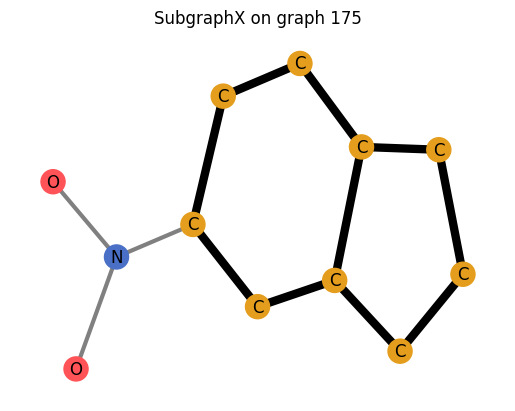

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


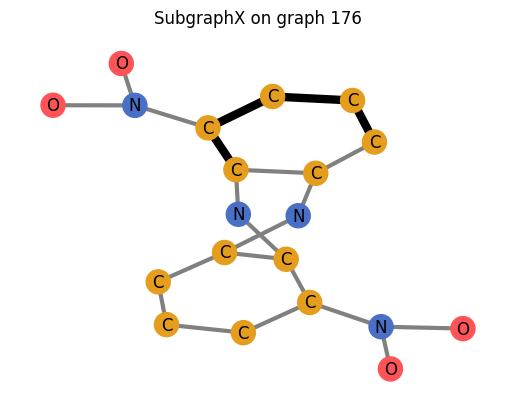

  0%|          | 0/20 [00:00<?, ?it/s]

1   0   0


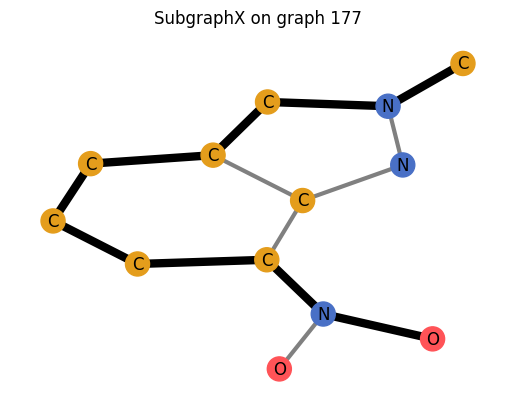

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


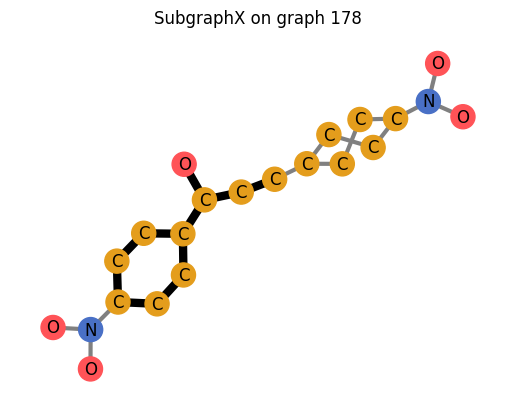

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


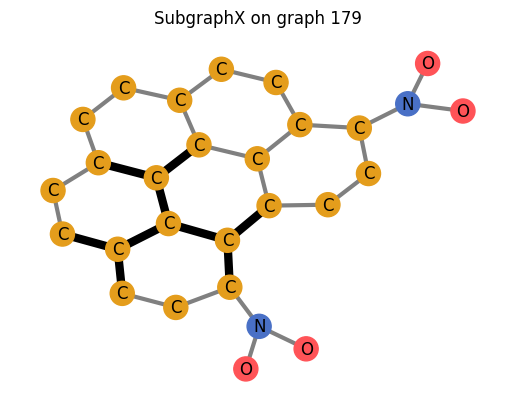

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


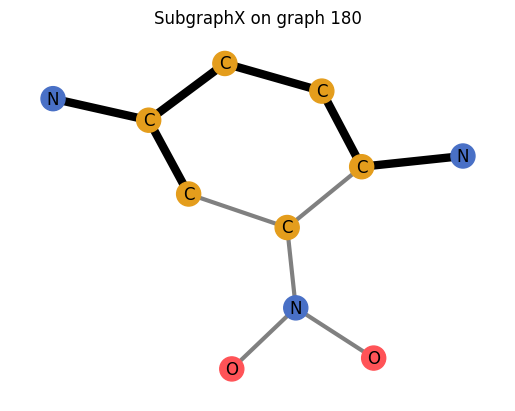

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


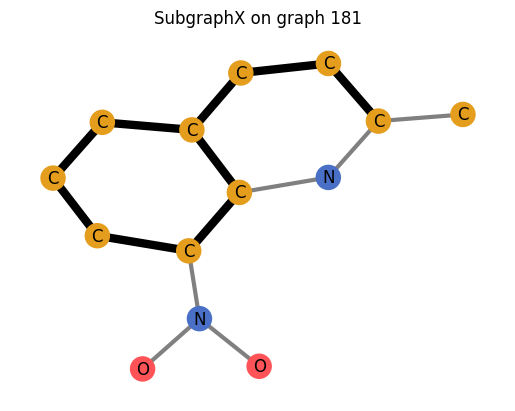

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


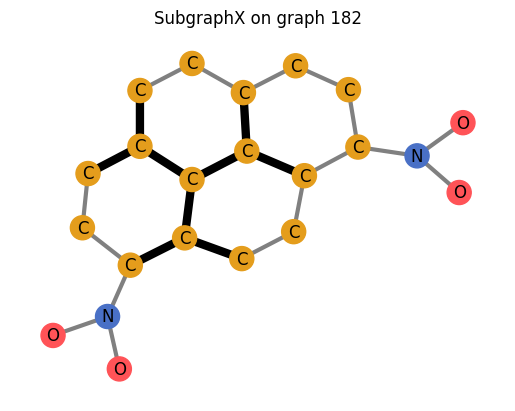

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


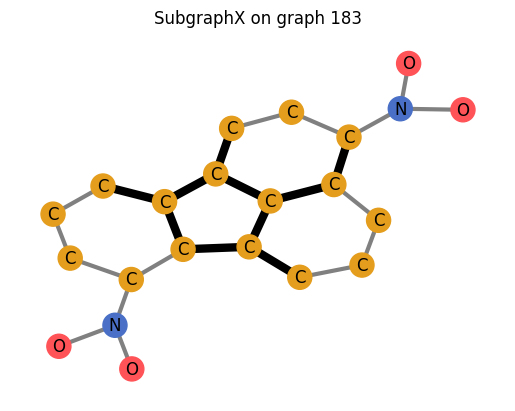

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


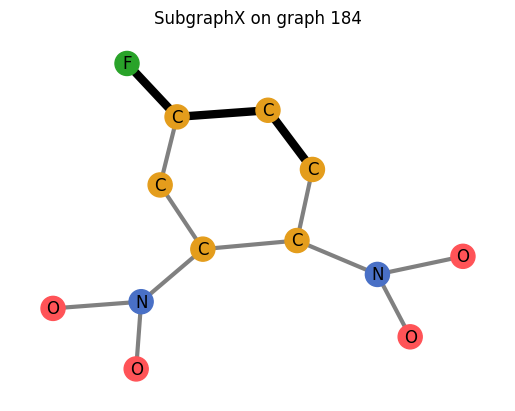

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   0


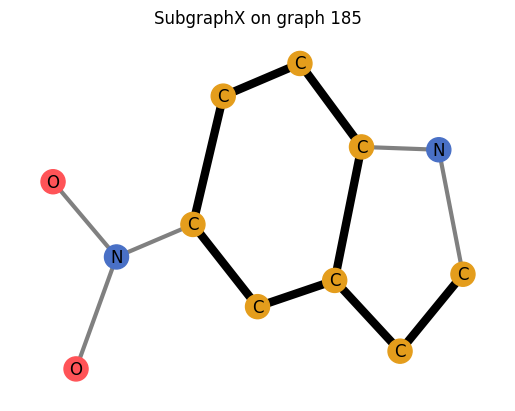

  0%|          | 0/20 [00:00<?, ?it/s]

1   1   1


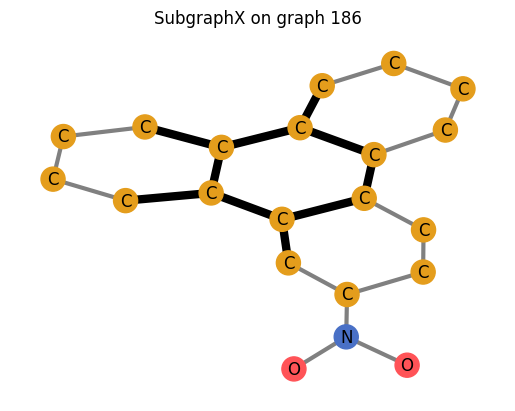

  0%|          | 0/20 [00:00<?, ?it/s]

0   0   1


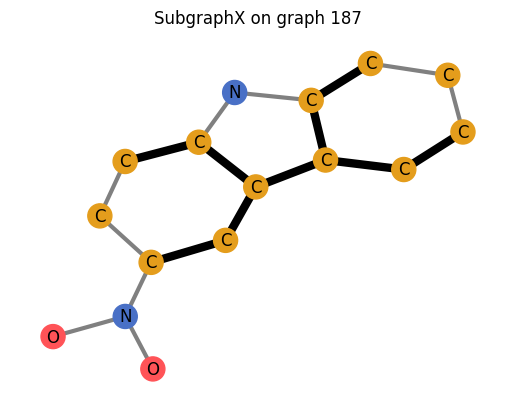

In [25]:
# Run SubgraphX and visualize the best subgraph for each graph
num_nodes = 10
mutag_dataset = edict()
mutag_dataset.ds = TUDataset(
    './dataset/mutag/',
    name='MUTAG',
    use_node_attr=True,
    use_edge_attr=True
)
subgraphx = SubgraphX(model=mutag_model, min_nodes=num_nodes)

for i, mutag_data in enumerate(mutag_dataset.ds[:188]):
    graph = to_networkx(mutag_data, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
    subgraph = subgraphx.explain(x=mutag_data.x.to(device), edge_index=mutag_data.edge_index.to(device), max_nodes=num_nodes)
    print(subgraph)
    print(truth[i], " ", original_pred[i], " ", new_pred[i])
    visualize_subgraph_mutag(
        graph=graph,
        node_set=set(subgraph.coalition),
        title=f'SubgraphX on graph {i}'
    )